<a href="https://colab.research.google.com/github/emirhangull/StrokePrediction/blob/training/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Emirhan Gül
Efe Arda Uzunova
Mete Oktar

# Inme (Stroke) Veri Analizi (EDA)
Bu bölümde veri setinin genel yapısını inceleyip, eksik değerler, sınıf dağılımı, sayısal ve kategorik değişkenlerin dağılımları ile temel ilişkileri görselleştireceğiz.

Hedefler:
- Veri setini yükleme ve genel bakış (boyut, sütunlar, tipler)
- Eksik değer analizi
- Hedef değişken dağılımı (sınıf dengesizliği)
- Sayısal değişkenler: dağılım ve aykırı değerler
- Kategorik değişkenler: sınıf kırılımında dağılımlar
- Korelasyon ısı haritası (sayısal özellikler + hedef)

Not: Bu aşamada yalnızca keşifsel analiz yapılır; dönüşüm/ölçekleme gibi adımlar bir sonraki bölümde ele alınacaktır.

In [4]:
# Gerekli Kütüphaneler (EDA)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Görsel ve çıktı ayarları
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f"{x:,.2f}")

sns.set(style="whitegrid", palette="Set2",
        rc={"axes.spines.right": False, "axes.spines.top": False})

%matplotlib inline

In [5]:
# 1) Veriyi Yükleme
import os

df = pd.read_csv('/data.csv')

print(f"Satır: {df.shape[0]:,} | Sütun: {df.shape[1]}")
display(df.head())

Satır: 5,110 | Sütun: 12


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.00,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1
1,51676,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.00,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1
3,60182,Female,49.00,0,0,Yes,Private,Urban,171.23,34.40,smokes,1
4,1665,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1


In [6]:
# 2) Genel Bakış: sütunlar, tipler, özet istatistikler
print('\nSütunlar:')

for i in list(df.columns):
    print(i)

print('\nVeri Tipleri:')
print(df.dtypes)

print('\nSayısal Özet :')
display(df.describe())


Sütunlar:
id
gender
age
hypertension
heart_disease
ever_married
work_type
Residence_type
avg_glucose_level
bmi
smoking_status
stroke

Veri Tipleri:
id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

Sayısal Özet :


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,"5,110.00","5,110.00","5,110.00","5,110.00","5,110.00","4,909.00","5,110.00"
mean,"36,517.83",43.23,0.10,0.05,106.15,28.89,0.05
std,"21,161.72",22.61,0.30,0.23,45.28,7.85,0.22
min,67.00,0.08,0.00,0.00,55.12,10.30,0.00
25%,"17,741.25",25.00,0.00,0.00,77.25,23.50,0.00
50%,"36,932.00",45.00,0.00,0.00,91.88,28.10,0.00
75%,"54,682.00",61.00,0.00,0.00,114.09,33.10,0.00
max,"72,940.00",82.00,1.00,1.00,271.74,97.60,1.00


In [7]:
print("N/A or Unknown values count by column")
df['smoking_status'] = df['smoking_status'].replace('Unknown', np.nan)
df.isna().sum()


N/A or Unknown values count by column


,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,201


Görüldüğü gibi sadece bmi (201) ve smoking status (1544) sütunlarında N/A ve unknown değerleri var.

In [8]:
print(
    f"BMI NaN sayısı: {df['bmi'].isnull().sum()} | "
    f"BMI NaN oranı: {df['bmi'].isnull().mean():.2%}\n"
    f"Smoking Unknown sayısı: {df['smoking_status'].isnull().sum()} | "
    f"Smoking Unknown oranı: {df['smoking_status'].isnull().mean():.2%}\n"
)
display(df['bmi'].describe())
display(df['smoking_status'].value_counts())




BMI NaN sayısı: 201 | BMI NaN oranı: 3.93%
Smoking Unknown sayısı: 1544 | Smoking Unknown oranı: 30.22%



,bmi
count,"4,909.00"
mean,28.89
std,7.85
min,10.30
25%,23.50
50%,28.10
75%,33.10
max,97.60


,count
smoking_status,
never smoked,1892
formerly smoked,885
smokes,789


Eksik değer sayıları ve yüzdeleri:


,missing,percent
smoking_status,1544,30.22
bmi,201,3.93


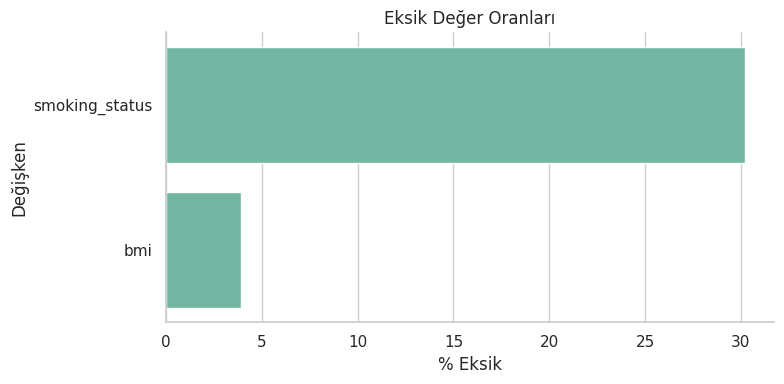

In [9]:
# 3) Eksik Değer Analizi


missing_counts = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing_counts / len(df)).sort_values(ascending=False)
missing_df = pd.DataFrame({
    'missing': missing_counts,
    'percent': (missing_pct * 100).round(2)
})

print('Eksik değer sayıları ve yüzdeleri:')
display(missing_df[missing_df['missing'] > 0])

plt.figure(figsize=(8, 4))
sns.barplot(x=missing_df[missing_df['missing']>0]['percent'],
            y=missing_df[missing_df['missing']>0].index,
            orient='h', color='#66c2a5')
plt.xlabel('% Eksik')
plt.ylabel('Değişken')
plt.title('Eksik Değer Oranları')
plt.tight_layout()
plt.show()

BMI'daki NaN değerleri medyan ile doldurulacak, Smoking_Status'teki Unknown değerleri ise ayrı bir kategori olarak ele alınacaktır.

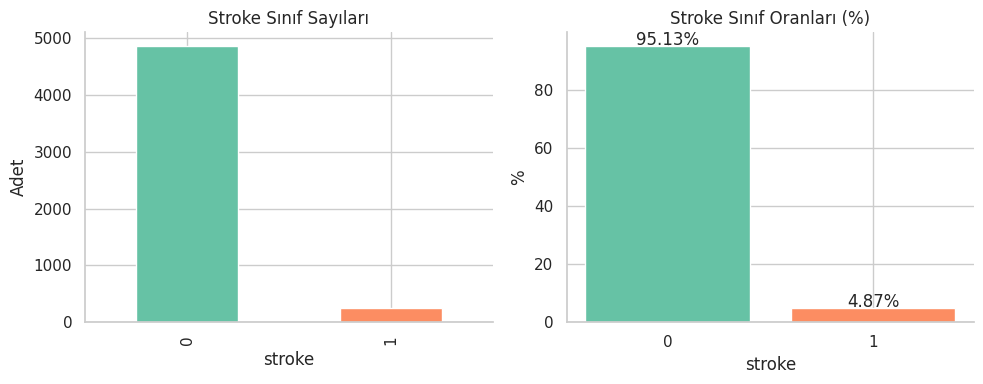

Sınıf oranları (%):
stroke
0   95.13
1    4.87
Name: count, dtype: float64


In [10]:
# 4)veride stroke dagilimi nasıl
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
vc = df['stroke'].value_counts().sort_index()
vc.plot(kind='bar', ax=ax[0], color=['#66c2a5', '#fc8d62'])
ax[0].set_title('Stroke Sınıf Sayıları')
ax[0].set_xlabel('stroke')
ax[0].set_ylabel('Adet')

ratio = (vc / vc.sum() * 100).round(2)
ax[1].bar(ratio.index.astype(str), ratio.values, color=['#66c2a5', '#fc8d62'])
ax[1].set_title('Stroke Sınıf Oranları (%)')
ax[1].set_xlabel('stroke')
ax[1].set_ylabel('%')
for i, v in enumerate(ratio.values):
    ax[1].text(i, v + 0.5, f"{v}%", ha='center')
plt.tight_layout()
plt.show()

print('Sınıf oranları (%):')
print(ratio)

İnme tahmininde bulunduğumuz için true positive'leri kaçırmamalıyız. Yani bütün true positiveleri yakalamamız ve false negative sayısını olabildiğince minimize etmemiz gerekiyor. Özetle Recall değerimizin 1'e olabildiğince yakın olması gerek.

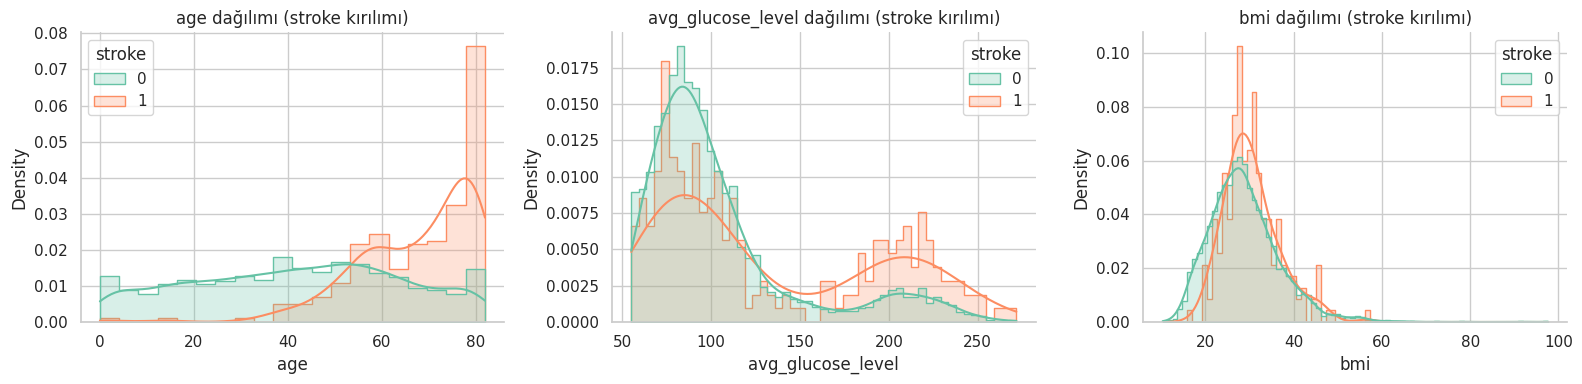

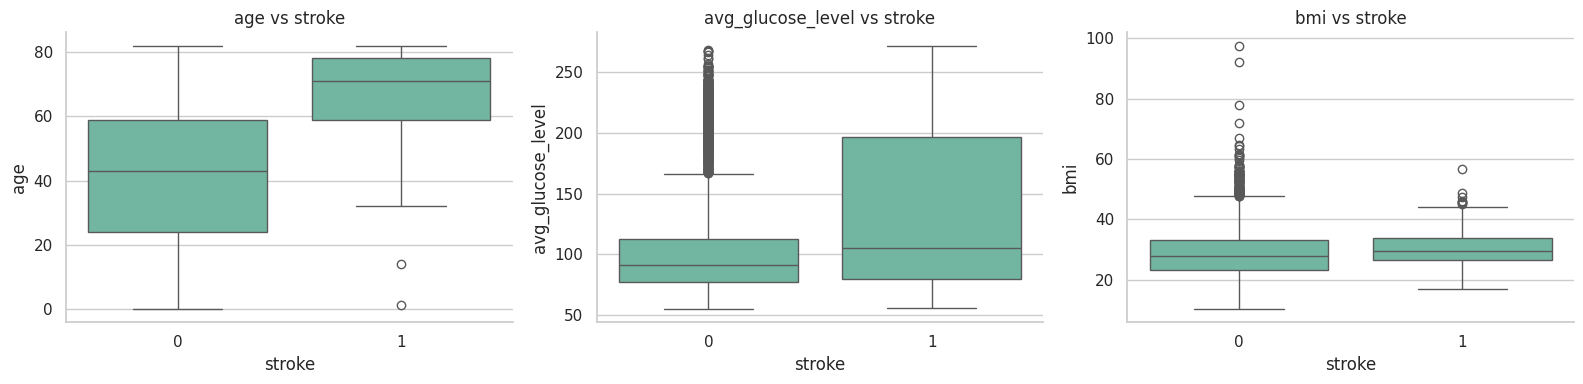

In [11]:

num_cols = ['age', 'avg_glucose_level', 'bmi']

# Histogram
fig, axes = plt.subplots(1, len(num_cols), figsize=(16, 4))
for i, col in enumerate(num_cols):
    sns.histplot(data=df, x=col, hue='stroke', element='step', stat='density',
                 common_norm=False, kde=True, ax=axes[i])
    axes[i].set_title(f'{col} dağılımı (stroke kırılımı)')
plt.tight_layout()
plt.show()

# Boxplot
fig, axes = plt.subplots(1, len(num_cols), figsize=(16, 4))
for i, col in enumerate(num_cols):
    sns.boxplot(data=df, x='stroke', y=col, ax=axes[i])
    axes[i].set_title(f'{col} vs stroke')
plt.tight_layout()
plt.show()

Histogram dağılımlarından yaş faktörünün inme geçirme ile yakından ilişkili olduğunu görebiliriz. Yaş arttıkça inme oranı artıyor.

Stroke ve avg glucose level grafiğinden de age kadar olmasa da şeker seviyesinin de inme geçirip geçirmemeyle ilişkili olduğunu görebiliyoruz.
Burada dikkat etmemiz gereken iki durum var

1- İnme değerinin 80 glucose_level değerlerinde peak etmesinin sebebi tüm insanlarda 70-126 mg/dL arasının normal değer kabul edilmesi ve insanların çoğunun bu aralıkta bulunması. Yani 80 civarında inme geçiren hastaların avg glucose degeriyle bir alakası yok denebilir.

2- Fakat inme değerinin 200 mg/dL civarında yeniden artmasının sebebi şekeri yüksek insanların inme geçirmeye daha eğilimli olması olarak yorumlanabilir.

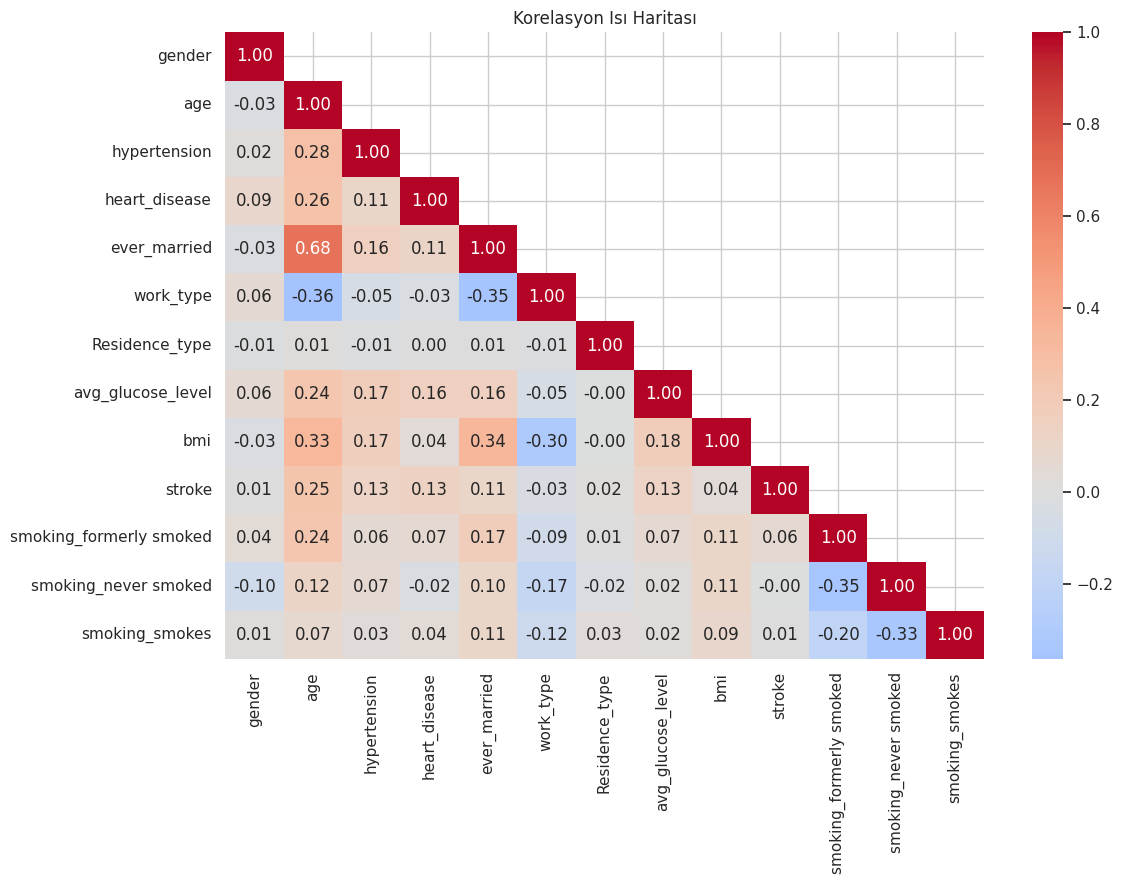


Stroke ile Korelasyonlar:
stroke                     1.00
age                        0.25
heart_disease              0.13
avg_glucose_level          0.13
hypertension               0.13
ever_married               0.11
smoking_formerly smoked    0.06
bmi                        0.04
Residence_type             0.02
smoking_smokes             0.01
gender                     0.01
smoking_never smoked      -0.00
work_type                 -0.03
Name: stroke, dtype: float64


In [12]:
# 6) Korelasyon Isı Haritası

# ana df etkilenmemesi için ayrı bir df
df_corr = df.copy().drop(columns=['id', 'age_group'], errors='ignore')

# smoking status'u one-hot-encode et
smoke_dummies = pd.get_dummies(df_corr['smoking_status'], prefix='smoking')
df_corr = pd.concat([df_corr.drop(columns=['smoking_status']), smoke_dummies], axis=1)

# kategorikleri label ile encoding
cat_cols = df_corr.select_dtypes(exclude=['number']).columns
le = LabelEncoder()
for col in cat_cols:
    df_corr[col] = le.fit_transform(df_corr[col].astype(str))

corr_all = df_corr.corr(numeric_only=True)

mask = np.triu(np.ones_like(corr_all, dtype=bool), k=1)

#heatmap
plt.figure(figsize=(12, 9))
sns.heatmap(corr_all, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Korelasyon Isı Haritası")
plt.tight_layout()
plt.show()

print("\nStroke ile Korelasyonlar:")
print(corr_all['stroke'].sort_values(ascending=False))

Bu korelasyon haritasından da görülebileceği gibi stroke ile korelasyonda yaş en büyük faktör iken, avg_glucose_level, heart_disease ve hypertension 2. sırada geliyor.

Öznitelikler arasındaki korelasyonları görebilmek de bu grafikten mümkün.
Yaş ve ever_married gibi

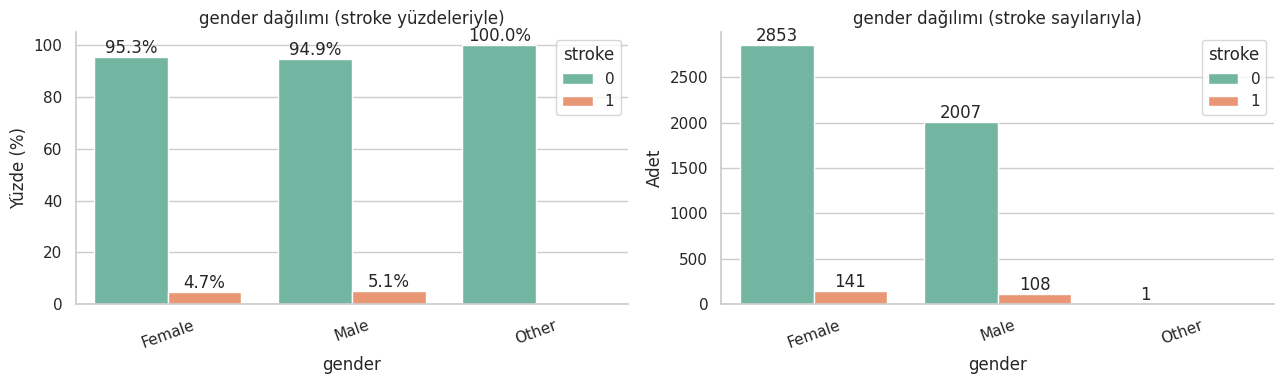

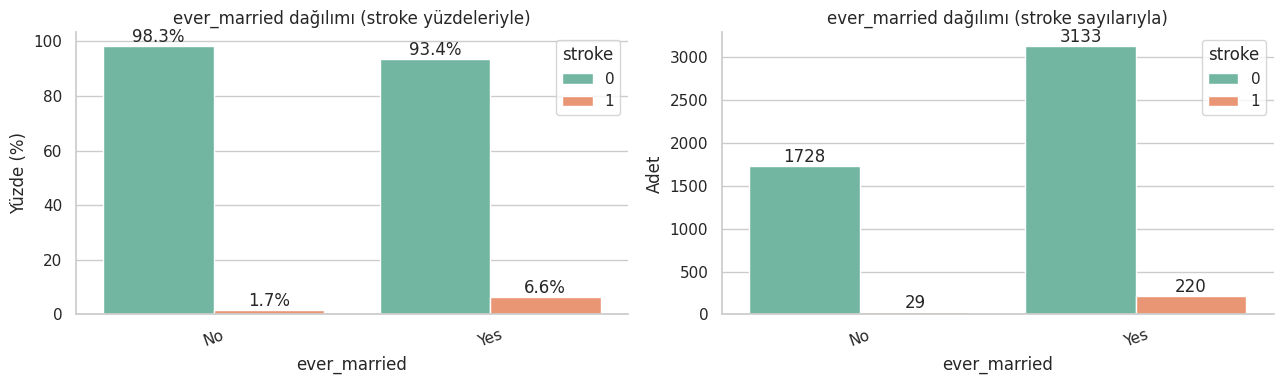

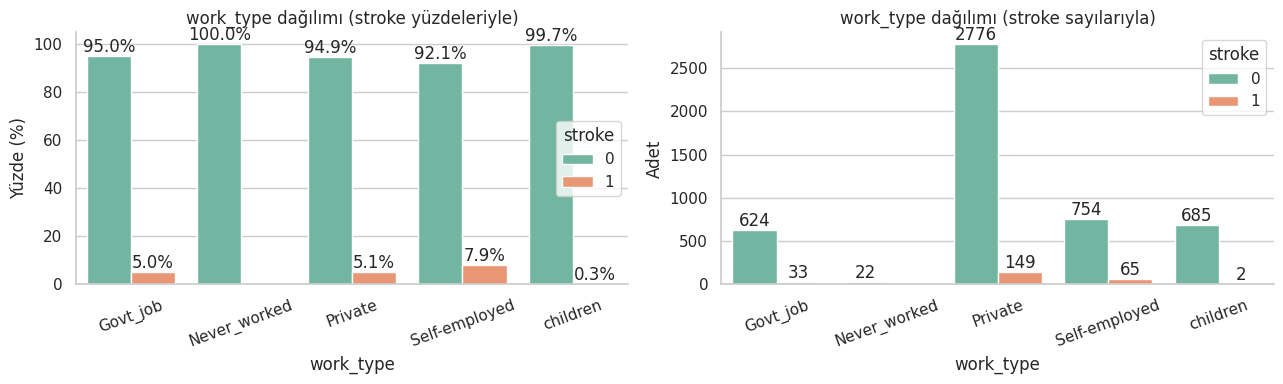

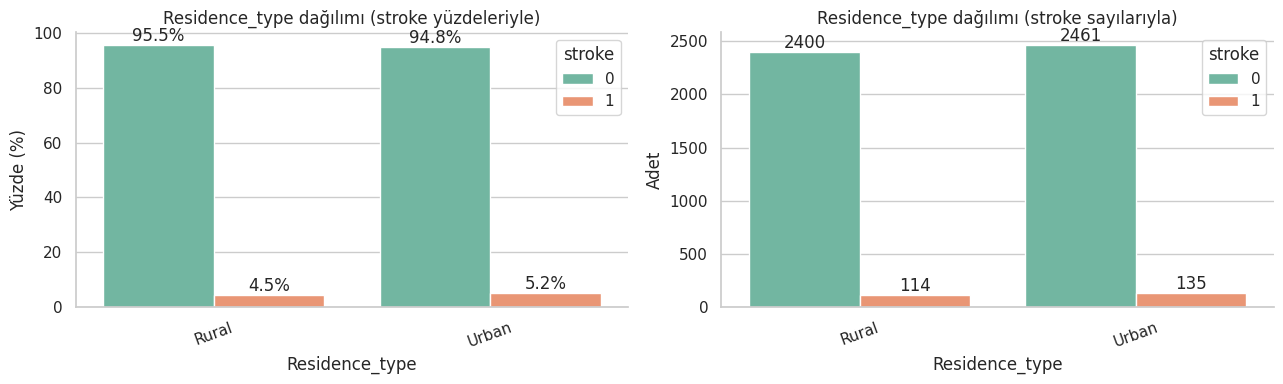

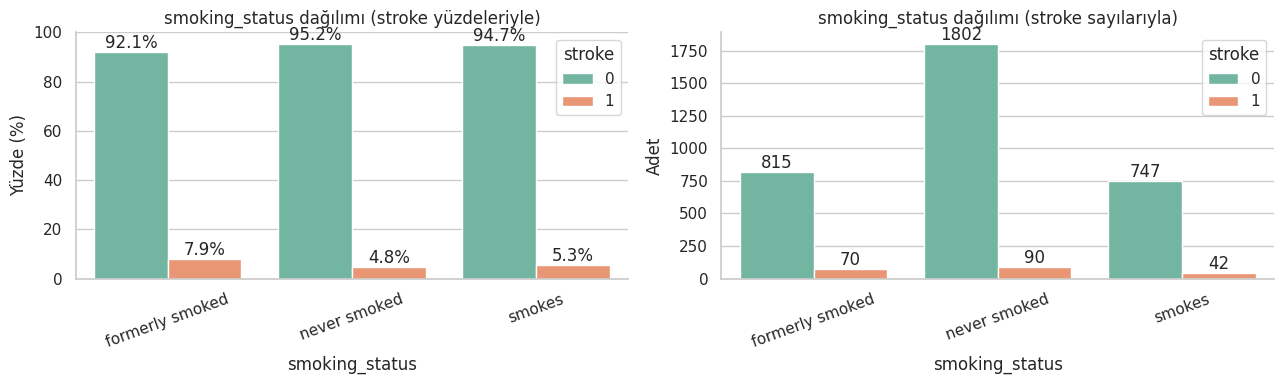

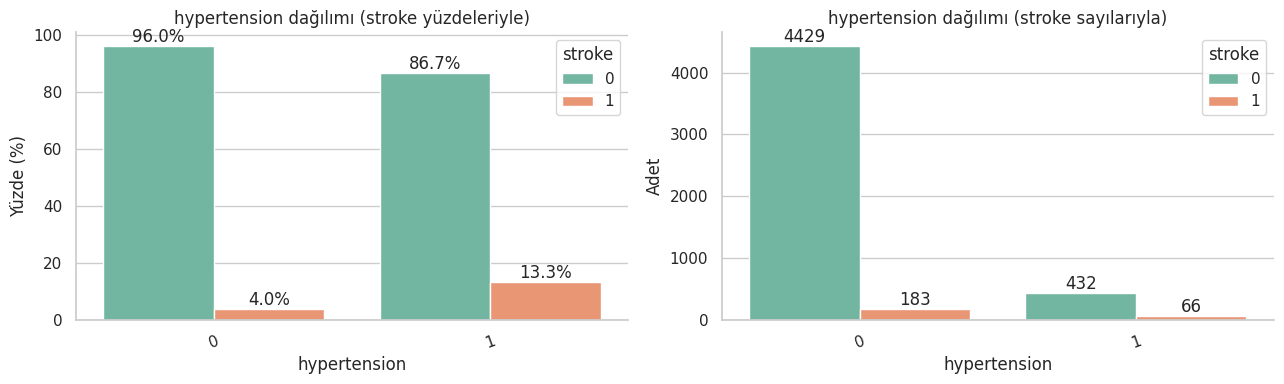

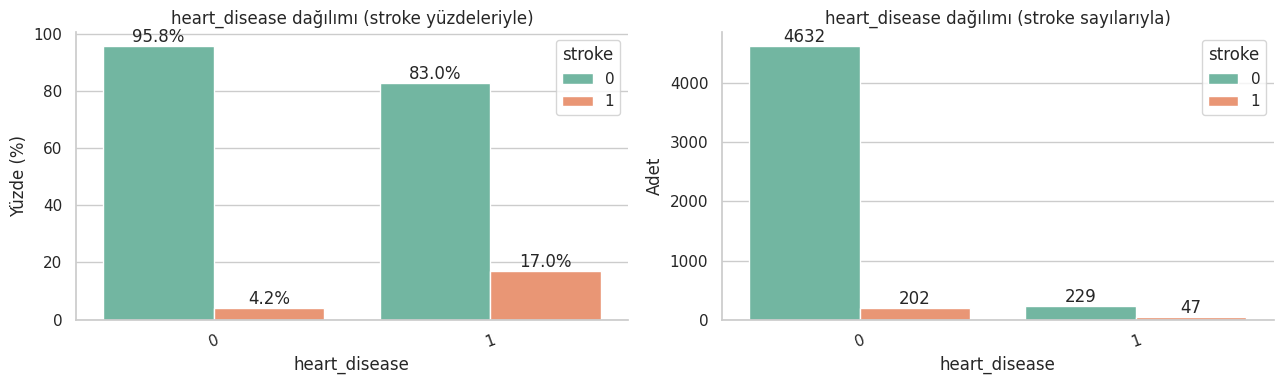

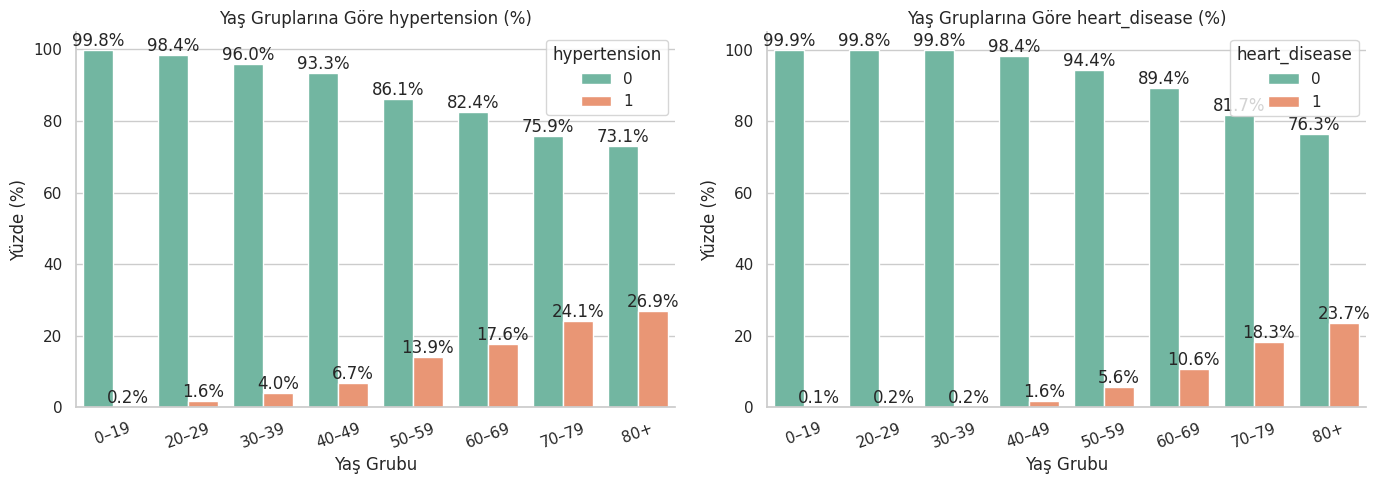

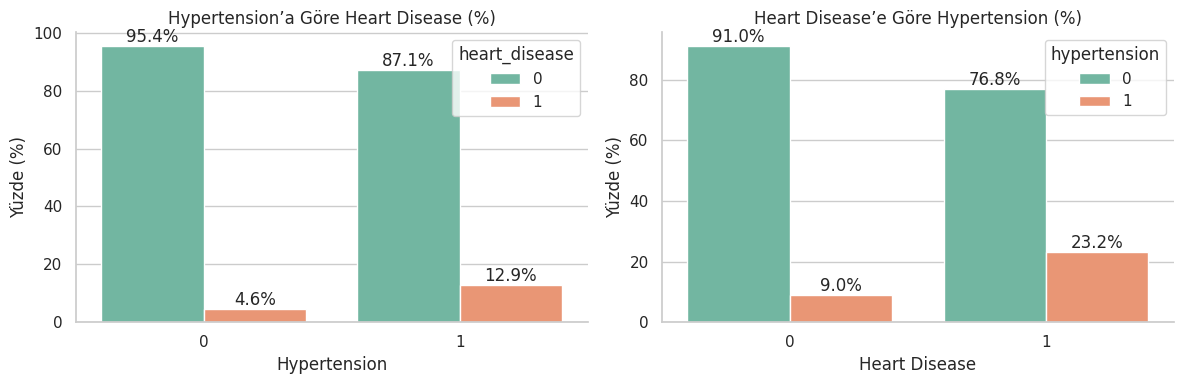

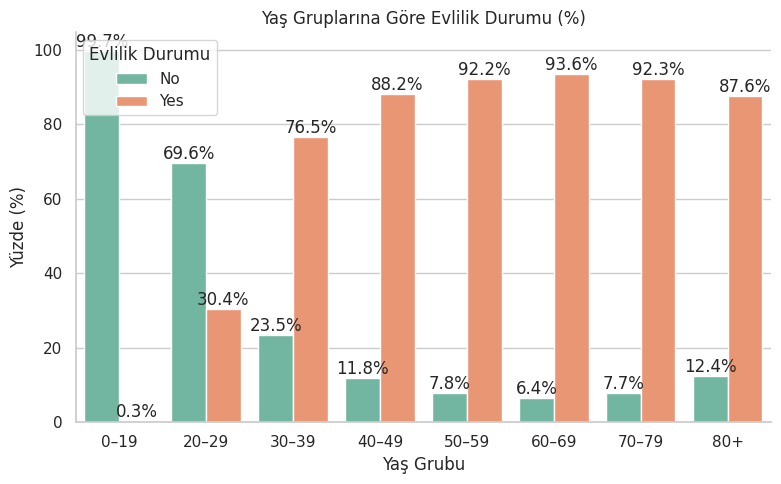

In [13]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# satir bazinda yuzde hesapliyor
def pct_table(df, x, hue):
    return (
        df.groupby([x, hue], observed=False)
          .size()
          .groupby(level=0, observed=False)
          .transform(lambda s: 100 * s / s.sum())
          .reset_index(name='percent')
    )

cat_cols = ['gender', 'ever_married', 'work_type', 'Residence_type',
            'smoking_status', 'hypertension', 'heart_disease']

for col in cat_cols:
    fig, axes = plt.subplots(1, 2, figsize=(13, 4))

    # percentile graph
    data_pct = pct_table(df, col, 'stroke')
    ax = sns.barplot(data=data_pct, x=col, y='percent', hue='stroke', ax=axes[0])
    for c in ax.containers:
        ax.bar_label(c, fmt='%.1f%%')
    axes[0].set_title(f'{col} dağılımı (stroke yüzdeleriyle)')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Yüzde (%)')
    axes[0].tick_params(axis='x', rotation=20)

    # sayisal graph
    data_count = df.groupby([col, 'stroke'], observed=False).size().reset_index(name='count')
    ax2 = sns.barplot(data=data_count, x=col, y='count', hue='stroke', ax=axes[1])
    for c in ax2.containers:
        ax2.bar_label(c, fmt='%d')
    axes[1].set_title(f'{col} dağılımı (stroke sayılarıyla)')
    axes[1].set_xlabel(col)
    axes[1].set_ylabel('Adet')
    axes[1].tick_params(axis='x', rotation=20)

    plt.tight_layout()
    plt.show()

#age binleri
bins   = [0, 20, 30, 40, 50, 60, 70, 80, 120]
labels = ['0–19', '20–29', '30–39', '40–49', '50–59', '60–69', '70–79', '80+']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
targets = ['hypertension', 'heart_disease']
#yas gruplarina gore hypertension ve heartdisease
for i, h in enumerate(targets):
    d = pct_table(df, 'age_group', h)
    ax = axes[i]
    sns.barplot(data=d, x='age_group', y='percent', hue=h, ax=ax)
    for c in ax.containers:
        ax.bar_label(c, fmt='%.1f%%')
    ax.set_title(f'Yaş Gruplarına Göre {h} (%)')
    ax.set_xlabel('Yaş Grubu')
    ax.set_ylabel('Yüzde (%)')
    ax.legend(title=h)
    ax.tick_params(axis='x', rotation=20)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# hypertension'u olan insanlar heart_disease'e daha mı yatkın
data_ht_hd = pct_table(df, 'hypertension', 'heart_disease')
sns.barplot(data=data_ht_hd, x='hypertension', y='percent',
            hue='heart_disease', ax=axes[0])
for c in axes[0].containers:
    axes[0].bar_label(c, fmt='%.1f%%')
axes[0].set_title('Hypertension’a Göre Heart Disease (%)')
axes[0].set_xlabel('Hypertension'); axes[0].set_ylabel('Yüzde (%)')

# heart_disease'i bulunan insanlar hypertension'a daha mı yatkın
data_hd_ht = pct_table(df, 'heart_disease', 'hypertension')
sns.barplot(data=data_hd_ht, x='heart_disease', y='percent',
            hue='hypertension', ax=axes[1])
for c in axes[1].containers:
    axes[1].bar_label(c, fmt='%.1f%%')
axes[1].set_title('Heart Disease’e Göre Hypertension (%)')
axes[1].set_xlabel('Heart Disease'); axes[1].set_ylabel('Yüzde (%)')

plt.tight_layout()
plt.show()

#yas gruplarina gore ever_married olup olmadigi
data_age_married = pct_table(df, 'age_group', 'ever_married')
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=data_age_married, x='age_group', y='percent', hue='ever_married')
for c in ax.containers:
    ax.bar_label(c, fmt='%.1f%%')
plt.title('Yaş Gruplarına Göre Evlilik Durumu (%)')
plt.xlabel('Yaş Grubu'); plt.ylabel('Yüzde (%)')
plt.legend(title='Evlilik Durumu')
plt.tight_layout(); plt.show()


In [14]:
dfcleaned=df.copy()

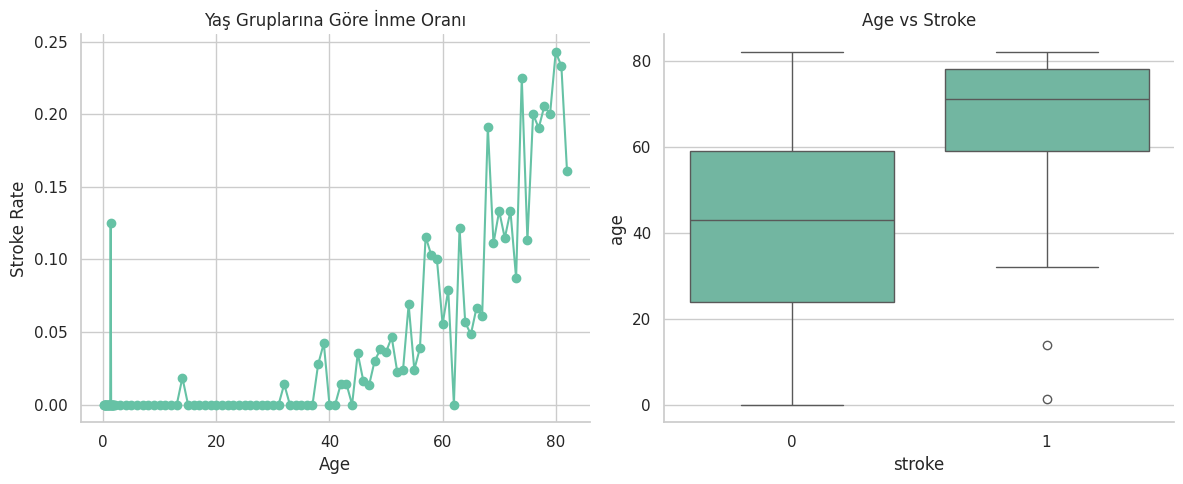

In [15]:
# Age vs Stroke
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
dfcleaned.groupby('age')['stroke'].mean().plot(marker='o')
plt.xlabel('Age')
plt.ylabel('Stroke Rate')
plt.title('Yaş Gruplarına Göre İnme Oranı')

plt.subplot(1, 2, 2)
sns.boxplot(data=dfcleaned, x='stroke', y='age')
plt.title('Age vs Stroke')
plt.tight_layout()
plt.show()

Yukarıdaki kategorik veri grafiklerinden de ilk bakışta heart_disease , hypertension , ever_married ve yaş verilerinin inme geçirip geçirmemeyle diğer değerlere göre daha ilişkili olduğunu görebiliriz. Fakat bu verilerin birbirlerinden bağımsız olmadığını, hem birbirleriyle hem de yaş ile ilişkili olduğunu göz önünde bulundurmalıyız. Örneğin:

1- yaş arttıkça ever_married değerinin 1 olma eğilimi artıyor

2- yaş arttıkça hypertension ve heart_disease olma eğilimi artıyor

3- heart_disease olduğu takdirde hypertension olma eğilimi artıyor

Yani yaş özniteliğinin diğer öznitelikleri de etkilediğini ve inme geçirip geçirmemenin en büyük indikatörü olduğunu anlayabiliriz.

Önceden sigara içmiş olmanın ya da halen sigara içiyor olmanın da inme riskini arttırdığını da söylemek mümkün.

DATA CLEANİNG & PREPROCESS AŞAMASI :

In [16]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group
0,9046,Male,67.00,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1,60–69
1,51676,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1,60–69
2,31112,Male,80.00,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1,80+
3,60182,Female,49.00,0,0,Yes,Private,Urban,171.23,34.40,smokes,1,40–49
4,1665,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1,70–79
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.00,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0,80+
5106,44873,Female,81.00,0,0,Yes,Self-employed,Urban,125.20,40.00,never smoked,0,80+
5107,19723,Female,35.00,0,0,Yes,Self-employed,Rural,82.99,30.60,never smoked,0,30–39
5108,37544,Male,51.00,0,0,Yes,Private,Rural,166.29,25.60,formerly smoked,0,50–59


In [17]:
dfcleaned = df.copy()

In [18]:
dfcleaned = dfcleaned.drop(columns=['id'], errors='ignore')

In [19]:
dfcleaned

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group
0,Male,67.00,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1,60–69
1,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1,60–69
2,Male,80.00,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1,80+
3,Female,49.00,0,0,Yes,Private,Urban,171.23,34.40,smokes,1,40–49
4,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1,70–79
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.00,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0,80+
5106,Female,81.00,0,0,Yes,Self-employed,Urban,125.20,40.00,never smoked,0,80+
5107,Female,35.00,0,0,Yes,Self-employed,Rural,82.99,30.60,never smoked,0,30–39
5108,Male,51.00,0,0,Yes,Private,Rural,166.29,25.60,formerly smoked,0,50–59


In [20]:
# BMI eksik değerlerini medyanla doldurma
dfcleaned['bmi'].fillna(dfcleaned['bmi'].median(), inplace=True)


/tmp/ipython-input-2904153404.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dfcleaned['bmi'].fillna(dfcleaned['bmi'].median(), inplace=True)


In [21]:
# Kontrol
dfcleaned['bmi'].isnull().sum()

np.int64(0)

In [22]:
# Smoking_status eksik değerlerini "Unknown" ile doldurma
dfcleaned['smoking_status'].fillna('Unknown', inplace=True)


/tmp/ipython-input-3019457198.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dfcleaned['smoking_status'].fillna('Unknown', inplace=True)


In [23]:
# Kontrol
dfcleaned['smoking_status'].isnull().sum()

np.int64(0)

In [24]:
# Kontrol
dfcleaned['smoking_status'].value_counts()

,count
smoking_status,
never smoked,1892
Unknown,1544
formerly smoked,885
smokes,789


In [25]:
dfcleaned

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group
0,Male,67.00,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1,60–69
1,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,28.10,never smoked,1,60–69
2,Male,80.00,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1,80+
3,Female,49.00,0,0,Yes,Private,Urban,171.23,34.40,smokes,1,40–49
4,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1,70–79
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.00,1,0,Yes,Private,Urban,83.75,28.10,never smoked,0,80+
5106,Female,81.00,0,0,Yes,Self-employed,Urban,125.20,40.00,never smoked,0,80+
5107,Female,35.00,0,0,Yes,Self-employed,Rural,82.99,30.60,never smoked,0,30–39
5108,Male,51.00,0,0,Yes,Private,Rural,166.29,25.60,formerly smoked,0,50–59


In [26]:
print(f"Toplam eksik değer sayısı: {dfcleaned.isnull().sum().sum()}")

Toplam eksik değer sayısı: 0


Şimdi DataFrame üzerinde bazı düzenlemeler yapalım

In [27]:
dfcleaned = dfcleaned.drop(columns=['age_group'])

In [28]:
dfcleaned['gender'].unique()

array(['Male', 'Female', 'Other'], dtype=object)

In [29]:
# Gender'i "Other" olan satırları filtrele
dfcleaned[dfcleaned['gender'] == 'Other']


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,Other,26.00,0,0,No,Private,Rural,143.33,22.40,formerly smoked,0


gender kolonundaki other değerleri 5110 satırda sadece 3 kez geçiyor ve sırf bu other değeri için one hot encoding yaptığımız zaman ayrıca bir kolon oluşacak ve 5107 tane 0,
3 tane 1 değeri içerecekti. Bu sebeple other değerleri çoğunluk olan female değeri ile replace edildi

In [30]:
dfcleaned['gender'] = dfcleaned['gender'].replace('Other', 'Female')


In [31]:
dfcleaned['gender'].unique()

array(['Male', 'Female'], dtype=object)

In [32]:
dfcleaned

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.00,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1
1,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,28.10,never smoked,1
2,Male,80.00,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1
3,Female,49.00,0,0,Yes,Private,Urban,171.23,34.40,smokes,1
4,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.00,1,0,Yes,Private,Urban,83.75,28.10,never smoked,0
5106,Female,81.00,0,0,Yes,Self-employed,Urban,125.20,40.00,never smoked,0
5107,Female,35.00,0,0,Yes,Self-employed,Rural,82.99,30.60,never smoked,0
5108,Male,51.00,0,0,Yes,Private,Rural,166.29,25.60,formerly smoked,0


In [33]:
dfcleaned = pd.get_dummies(dfcleaned, columns=['gender'], drop_first=True, dtype=int)

age kolonu:
Modelin yaş ile stroke arasındaki doğrusal veya doğrusal olmayan ilişkiyi öğrenmesini istiyoruz. Bu sebeple age kolonu numerik olarak kalacak.
Ayrıca binning ile non-linear patternleri daha iyi yakalamasını isteyebiliriz. Buna modeli train ettikten sonra performans karşılaştırması yaparak karar vereceğiz.

hypertension kolonu:
Binary (0–1) bir özellik olduğu için bu kolonu olduğu formda bırakıyoruz.

In [34]:
# Hypertension unique değerleri
print(dfcleaned['hypertension'].unique())
print(f"\nHypertension dağılımı:")
print(dfcleaned['hypertension'].value_counts())

[0 1]

Hypertension dağılımı:
hypertension
0    4612
1     498
Name: count, dtype: int64


heart_disease kolonu:
Binary (0–1) bir özellik olduğu için bu kolonu olduğu formda bırakıyoruz.

In [35]:
# heart_disease unique değerleri
print(dfcleaned['heart_disease'].unique())
print(f"\nHeart Disease dağılımı:")
print(dfcleaned['heart_disease'].value_counts())

[1 0]

Heart Disease dağılımı:
heart_disease
0    4834
1     276
Name: count, dtype: int64



ever_married kolonu:
modelin yes,no gibi string değerlerini anlayamayacağı için 0/1 değişkenlerine dönüştürüyoruz yani one hot encoding yapıyoruz.

In [36]:
# ever_married unique değerleri
print(dfcleaned['ever_married'].unique())
print(f"\nEver Married dağılımı:")
print(dfcleaned['ever_married'].value_counts())

['Yes' 'No']

Ever Married dağılımı:
ever_married
Yes    3353
No     1757
Name: count, dtype: int64


In [37]:
# ever_married kolonuna one-hot encoding yap
dfcleaned = pd.get_dummies(dfcleaned, columns=['ever_married'], prefix='ever_married', drop_first=True, dtype=int)


work_type kolonu:
Sınıflar arasında sıralama (ordinal) yok.
bu yüzden one hot encoding yaparız.

In [38]:
# work_type unique değerleri
print(dfcleaned['work_type'].unique())
print(f"\nWork Type dağılımı:")
print(dfcleaned['work_type'].value_counts())

['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']

Work Type dağılımı:
work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64


In [39]:
# work_type kolonuna one-hot encoding
dfcleaned = pd.get_dummies(dfcleaned, columns=['work_type'], prefix='work_type',
                             drop_first=True, dtype=int)



Residence_type kolonu:

In [40]:
# Residence_type unique değerleri
print(dfcleaned['Residence_type'].unique())
print(f"\nResidence Type dağılımı:")
print(dfcleaned['Residence_type'].value_counts())

['Urban' 'Rural']

Residence Type dağılımı:
Residence_type
Urban    2596
Rural    2514
Name: count, dtype: int64


In [41]:
dfcleaned = pd.get_dummies(dfcleaned, columns=['Residence_type'], prefix='Residence_type',
                             drop_first=True, dtype=int)

avg_glucose_level kolonu:

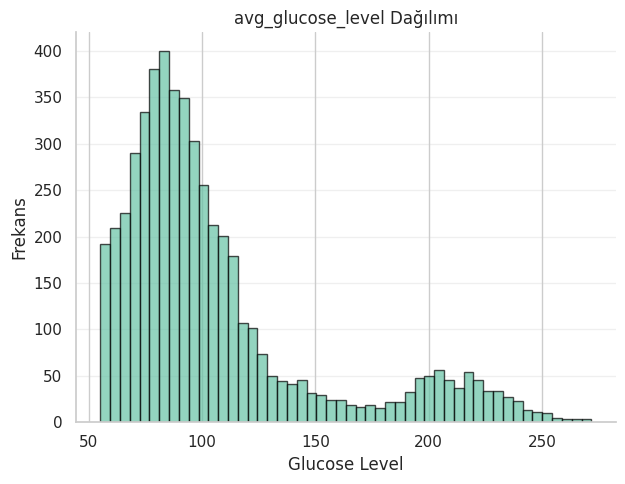

In [42]:
# avg_glucose_level histogram grafiği
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(dfcleaned['avg_glucose_level'], bins=50, edgecolor='black', color='#66c2a5', alpha=0.7)
plt.xlabel('Glucose Level')
plt.ylabel('Frekans')
plt.title('avg_glucose_level Dağılımı')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [43]:
# İstatistiksel özet
print(dfcleaned['avg_glucose_level'].describe())
print(f"\nMin: {dfcleaned['avg_glucose_level'].min()}")
print(f"Max: {dfcleaned['avg_glucose_level'].max()}")
print(f"Ortalama: {dfcleaned['avg_glucose_level'].mean():.2f}")
print(f"Medyan: {dfcleaned['avg_glucose_level'].median():.2f}")
print(f"Std Dev: {dfcleaned['avg_glucose_level'].std():.2f}")
print(f"Mode: {dfcleaned['avg_glucose_level'].mode()[0]:.2f}")

count   5,110.00
mean      106.15
std        45.28
min        55.12
25%        77.25
50%        91.88
75%       114.09
max       271.74
Name: avg_glucose_level, dtype: float64

Min: 55.12
Max: 271.74
Ortalama: 106.15
Medyan: 91.88
Std Dev: 45.28
Mode: 93.88


In [44]:
# Aykırı değer analizi (IQR yöntemi)
Q1 = dfcleaned['avg_glucose_level'].quantile(0.25)
Q3 = dfcleaned['avg_glucose_level'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = dfcleaned[(dfcleaned['avg_glucose_level'] < lower_bound) |
                      (dfcleaned['avg_glucose_level'] > upper_bound)]

print(f"Q1: {Q1:.2f}")
print(f"Q3: {Q3:.2f}")
print(f"IQR: {IQR:.2f}")
print(f"Lower Bound: {lower_bound:.2f}")
print(f"Upper Bound: {upper_bound:.2f}")
print(f"\nAykırı değer sayısı: {len(outliers)}")
print(f"Aykırı değer oranı: {len(outliers)/len(dfcleaned)*100:.2f}%")

Q1: 77.25
Q3: 114.09
IQR: 36.84
Lower Bound: 21.98
Upper Bound: 169.36

Aykırı değer sayısı: 627
Aykırı değer oranı: 12.27%


Aykırı değer sayısı çok fazla.
Sağa çarpık bir dağılıma sahip.
Log transformation yapalım:
Bu log dönüşümü dağılımı daha simetrik hale getirir ve modeli daha stabil hale getirir.
Yüksek uç değerlerin etkisini azaltarak modelin glukoza aşırı duyarlı olmasını engeller ve tahmin performansını artırır.

In [45]:
# Log transformation
dfcleaned['avg_glucose_level_log'] = np.log1p(dfcleaned['avg_glucose_level'])


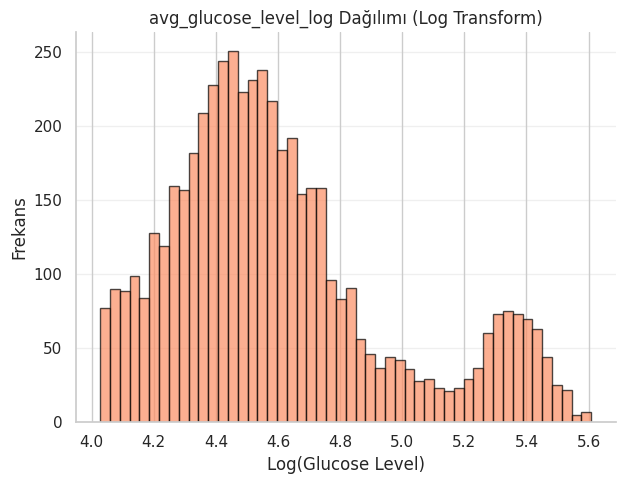

In [46]:
# Log transformation sonrası histogram grafiği
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(dfcleaned['avg_glucose_level_log'], bins=50, edgecolor='black', color='#fc8d62', alpha=0.7)
plt.xlabel('Log(Glucose Level)')
plt.ylabel('Frekans')
plt.title('avg_glucose_level_log Dağılımı (Log Transform)')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

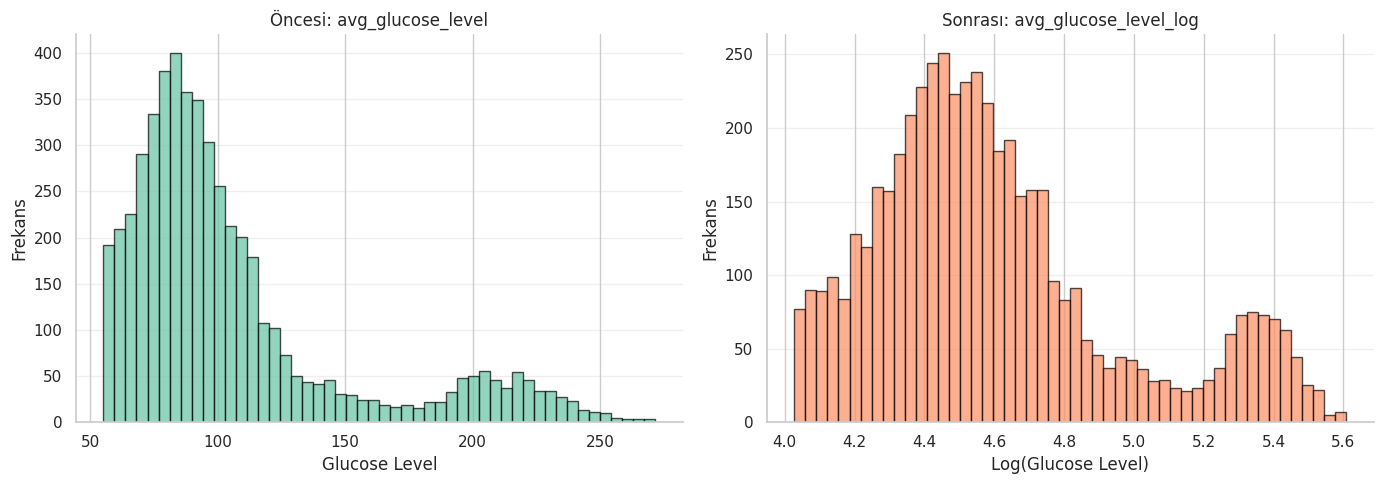

In [47]:
# Öncesi ve sonrası karşılaştırma
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Orijinal
axes[0].hist(dfcleaned['avg_glucose_level'], bins=50, edgecolor='black', color='#66c2a5', alpha=0.7)
axes[0].set_xlabel('Glucose Level')
axes[0].set_ylabel('Frekans')
axes[0].set_title('Öncesi: avg_glucose_level')
axes[0].grid(axis='y', alpha=0.3)

# Log Transform
axes[1].hist(dfcleaned['avg_glucose_level_log'], bins=50, edgecolor='black', color='#fc8d62', alpha=0.7)
axes[1].set_xlabel('Log(Glucose Level)')
axes[1].set_ylabel('Frekans')
axes[1].set_title('Sonrası: avg_glucose_level_log')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

Log dönüşümden sonra:
Dağılım çok daha simetrik
Sağ kuyruk büzüşmüş
Aykırı  etkisi yumuşamış

In [48]:
# Log transform sonrası aykırı değer analizi
Q1_log = dfcleaned['avg_glucose_level_log'].quantile(0.25)
Q3_log = dfcleaned['avg_glucose_level_log'].quantile(0.75)
IQR_log = Q3_log - Q1_log

lower_bound_log = Q1_log - 1.5 * IQR_log
upper_bound_log = Q3_log + 1.5 * IQR_log

outliers_log = dfcleaned[(dfcleaned['avg_glucose_level_log'] < lower_bound_log) |
                          (dfcleaned['avg_glucose_level_log'] > upper_bound_log)]

print(f"=== LOG TRANSFORM SONRASI AYKIRI DEĞER ANALİZİ ===")
print(f"Q1: {Q1_log:.2f}")
print(f"Q3: {Q3_log:.2f}")
print(f"IQR: {IQR_log:.2f}")
print(f"Alt Sınır: {lower_bound_log:.2f}")
print(f"Üst Sınır: {upper_bound_log:.2f}")
print(f"\nAykırı değer sayısı: {len(outliers_log)}")
print(f"Aykırı değer oranı: {len(outliers_log)/len(dfcleaned)*100:.2f}%")

=== LOG TRANSFORM SONRASI AYKIRI DEĞER ANALİZİ ===
Q1: 4.36
Q3: 4.75
IQR: 0.39
Alt Sınır: 3.78
Üst Sınır: 5.32

Aykırı değer sayısı: 384
Aykırı değer oranı: 7.51%


Aykırı değer oranı 12.27% değerinden 7.51% ye düşmüş oldu.
Böylece modeli uç değerlere daha az duyarlı hale getirdik.
Ama tamamen uç değerleri kaldırmadık çünkü uç değerler gerçek hastalık değerlerini temsil eder

In [49]:
dfcleaned

,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,avg_glucose_level_log
0,67.00,0,1,228.69,36.60,formerly smoked,1,1,1,0,1,0,0,1,5.44
1,61.00,0,0,202.21,28.10,never smoked,1,0,1,0,0,1,0,0,5.31
2,80.00,0,1,105.92,32.50,never smoked,1,1,1,0,1,0,0,0,4.67
3,49.00,0,0,171.23,34.40,smokes,1,0,1,0,1,0,0,1,5.15
4,79.00,1,0,174.12,24.00,never smoked,1,0,1,0,0,1,0,0,5.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,80.00,1,0,83.75,28.10,never smoked,0,0,1,0,1,0,0,1,4.44
5106,81.00,0,0,125.20,40.00,never smoked,0,0,1,0,0,1,0,1,4.84
5107,35.00,0,0,82.99,30.60,never smoked,0,0,1,0,0,1,0,0,4.43
5108,51.00,0,0,166.29,25.60,formerly smoked,0,1,1,0,1,0,0,0,5.12


Ağaç tabanlı modeller olan Decision Tree ve Random Forest, veri ölçeklemeye duyarlı olmadıkları ve ham dağılımdan daha fazla bilgi çıkarabildikleri için avg_glucose_level değişkeninin orijinal (raw) halini kullanmak en doğru yaklaşımdır.

Benzer şekilde XGBoost ve LightGBM de ham veriyi çok iyi işlediğinden raw değer idealdir.

Buna karşılık Logistic Regression, SVM, KNN ve Neural Network gibi lineer ya da mesafe tabanlı algoritmalar sağa çarpık dağılımlardan ve uç değerlerden doğrudan etkilendiği için bu modellerde log dönüşümü yapılmış ve ölçeklendirilmiş (log + scaled) glukoz değişkeni kullanılmalıdır. Bu sayede hem dağılım normalize edilmiş olur hem de tüm feature’lar aynı ölçekte işlendiği için model kararlılığı ve performansı artar.

Bu nedenle, projede kullanılacak modellere göre glukoz değişkeninin temsili değişmekte; ağaç tabanlı modellerde raw, lineer ve mesafe tabanlı modellerde ise log + scaled versiyon tercih edilmektedir.

In [50]:
# Log + Scaled transformation
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
dfcleaned['avg_glucose_level_log_scaled'] = scaler.fit_transform(
    dfcleaned[['avg_glucose_level_log']]
)

bmi kolonu:
BMI, dağılımı düzgün olsa da Logistic Regression ve SVM gibi ölçek duyarlı modellerin daha doğru ve stabil çalışması için ortak bir ölçeğe getirilmesi gerektiğinden scale edilmiştir.

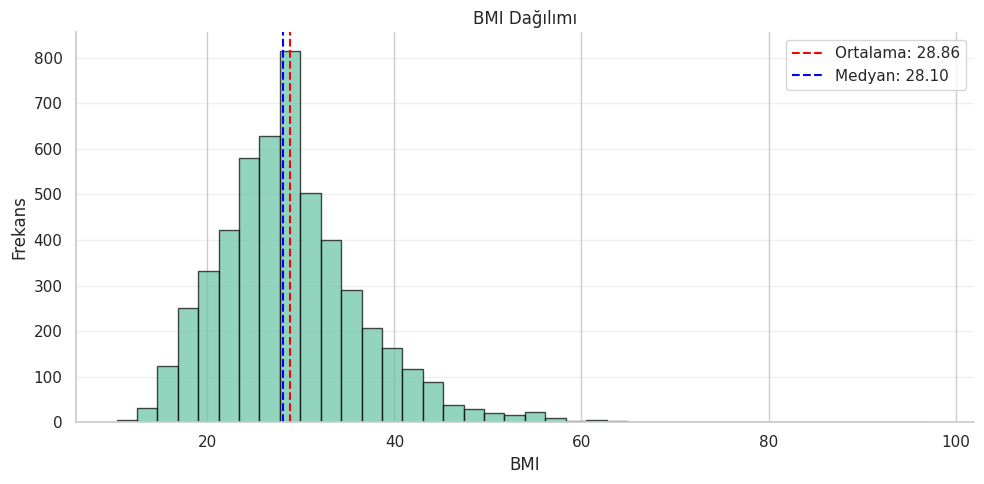

In [51]:
# BMI histogram grafiği
plt.figure(figsize=(10, 5))
plt.hist(dfcleaned['bmi'], bins=40, edgecolor='black', color='#66c2a5', alpha=0.7)
plt.xlabel('BMI')
plt.ylabel('Frekans')
plt.title('BMI Dağılımı')
plt.axvline(dfcleaned['bmi'].mean(), color='red', linestyle='--', label=f'Ortalama: {dfcleaned["bmi"].mean():.2f}')
plt.axvline(dfcleaned['bmi'].median(), color='blue', linestyle='--', label=f'Medyan: {dfcleaned["bmi"].median():.2f}')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [52]:
# 3) Aykırı değer analizi
Q1_bmi = dfcleaned['bmi'].quantile(0.25)
Q3_bmi = dfcleaned['bmi'].quantile(0.75)
IQR_bmi = Q3_bmi - Q1_bmi

lower_bound_bmi = Q1_bmi - 1.5 * IQR_bmi
upper_bound_bmi = Q3_bmi + 1.5 * IQR_bmi

outliers_bmi = dfcleaned[(dfcleaned['bmi'] < lower_bound_bmi) |
                          (dfcleaned['bmi'] > upper_bound_bmi)]

print(f"\n2️⃣ Aykırı Değer Analizi (IQR Yöntemi):")
print(f"Q1: {Q1_bmi:.2f}")
print(f"Q3: {Q3_bmi:.2f}")
print(f"IQR: {IQR_bmi:.2f}")
print(f"Alt Sınır: {lower_bound_bmi:.2f}")
print(f"Üst Sınır: {upper_bound_bmi:.2f}")
print(f"\nAykırı değer sayısı: {len(outliers_bmi)}")
print(f"Aykırı değer oranı: {len(outliers_bmi)/len(dfcleaned)*100:.2f}%")



2️⃣ Aykırı Değer Analizi (IQR Yöntemi):
Q1: 23.80
Q3: 32.80
IQR: 9.00
Alt Sınır: 10.30
Üst Sınır: 46.30

Aykırı değer sayısı: 126
Aykırı değer oranı: 2.47%


In [53]:
dfcleaned['bmi_scaled'] = scaler.fit_transform(dfcleaned[['bmi']])

BMI Kolonunun Modellerde Kullanımı

Lojistik Regresyon: Ölçek duyarlı bir model olduğu için scaled BMI kullanılmalıdır.

Decision Tree: Ağaç tabanlı yapılar ölçeklemeye ihtiyaç duymaz; bu nedenle orijinal BMI tercih edilir.

Random Forest: Ensemble ağaç modelleri ham veriyi daha iyi işler; orijinal BMI kullanılmalıdır.

SVM (opsiyonel): Mesafe temelli bir algoritma olduğundan scaled BMI zorunludur.

XGBoost (opsiyonel): Boosting yöntemleri ham sayısal değerleri etkili şekilde işlediği için orijinal BMI kullanılmalıdır.

Smoking status kolonu:
Sigara bilgisi bilinmeyen kişilerde inme riski farklı olabilir → model bunu öğrenmeli.
Kategorik bir kolon olduğundan one hot encoding yapılmalı.

In [54]:
# smoking_status kolonu analizi
print(dfcleaned['smoking_status'].unique())
print(f"\nSmoking Status dağılımı:")
print(dfcleaned['smoking_status'].value_counts())

['formerly smoked' 'never smoked' 'smokes' 'Unknown']

Smoking Status dağılımı:
smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64


In [55]:
dfcleaned = pd.get_dummies(dfcleaned, columns=['smoking_status'], drop_first=True, dtype=int)

In [56]:
dfcleaned.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,avg_glucose_level_log,avg_glucose_level_log_scaled,bmi_scaled,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.00,0,1,228.69,36.60,1,1,1,0,1,0,0,1,5.44,2.32,1.01,1,0,0
1,61.00,0,0,202.21,28.10,1,0,1,0,0,1,0,0,5.31,1.98,-0.10,0,1,0
2,80.00,0,1,105.92,32.50,1,1,1,0,1,0,0,0,4.67,0.19,0.47,0,1,0
3,49.00,0,0,171.23,34.40,1,0,1,0,1,0,0,1,5.15,1.52,0.72,0,0,1
4,79.00,1,0,174.12,24.00,1,0,1,0,0,1,0,0,5.17,1.57,-0.63,0,1,0


In [57]:
dfcleaned.dtypes

,0
age,float64
hypertension,int64
heart_disease,int64
avg_glucose_level,float64
bmi,float64
stroke,int64
gender_Male,int64
ever_married_Yes,int64
work_type_Never_worked,int64
work_type_Private,int64


Böylece "dfcleaned" Modellenmeye hazır bir dataframe haline getirilmiştir.

TRAINING

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

In [59]:

# dfcleaned yoksa üstteki satırların çalıştırılması gerekebilir.

# Feature Seçimi
# Logistic Regression için uygun feature'ları seçiyoruz.
# Not: Tree modelleri için raw veriler daha iyi olabilir ama LR için scaled versiyonlar şart.
scaler = StandardScaler()
dfcleaned['age_scaled'] = scaler.fit_transform(dfcleaned[['age']])
#age_scaled olmadıgından ekledik

lr_features = [
    'age_scaled',
    'hypertension',
    'heart_disease',
    'avg_glucose_level_log_scaled',
    'bmi_scaled',
    'gender_Male',
    'ever_married_Yes',
    'work_type_Never_worked',
    'work_type_Private',
    'work_type_Self-employed',
    'work_type_children',
    'Residence_type_Urban',
    'smoking_status_formerly smoked',
    'smoking_status_never smoked',
    'smoking_status_smokes'
]



print("Kullanılacak Feature'lar:", lr_features)

# 2. X ve y Ayrımı
X = dfcleaned[lr_features]
y = dfcleaned['stroke']

# 3. Train / Test Ayrımı
# Stratify=y diyerek inme oranını (dengesizliği) her iki sette de koruyoruz.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("-" * 30)
print(f"Train Set Boyutu: {X_train.shape}")
print(f"Test Set Boyutu : {X_test.shape}")
print("-" * 30)
print(f"Train içindeki İnme (1) Oranı: {y_train.mean():.4f}")
print(f"Test içindeki İnme (1) Oranı : {y_test.mean():.4f}")


Kullanılacak Feature'lar: ['age_scaled', 'hypertension', 'heart_disease', 'avg_glucose_level_log_scaled', 'bmi_scaled', 'gender_Male', 'ever_married_Yes', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes']
------------------------------
Train Set Boyutu: (4088, 15)
Test Set Boyutu : (1022, 15)
------------------------------
Train içindeki İnme (1) Oranı: 0.0487
Test içindeki İnme (1) Oranı : 0.0489


In [60]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

In [61]:
# SMOTE + StandarScaler + Logistic Regression Pipeline
logreg_pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('scale', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'))
])

print("Model Eğitiliyor...")
logreg_pipeline.fit(X_train, y_train)
print("Eğitim Tamamlandı.")

Model Eğitiliyor...
Eğitim Tamamlandı.


In [62]:
y_pred = logreg_pipeline.predict(X_test)
y_pred_proba = logreg_pipeline.predict_proba(X_test)[:, 1]  # ROC-AUC için

In [63]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.76      0.86       972
           1       0.14      0.76      0.23        50

    accuracy                           0.76      1022
   macro avg       0.56      0.76      0.55      1022
weighted avg       0.94      0.76      0.83      1022

ROC-AUC Score: 0.8269


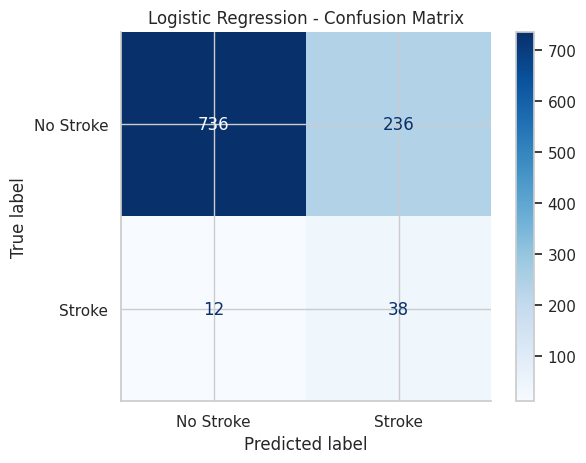

In [64]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Stroke', 'Stroke'])
disp.plot(cmap='Blues')
plt.title("Logistic Regression - Confusion Matrix")
plt.show()

In [65]:
#RANDOM FOREST ICIN IMPORT
from sklearn.ensemble import RandomForestClassifier

In [66]:
# SMOTE + StandardScaler + Random Forest Pipeline
rf_pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('scale', StandardScaler()),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ))
])

print("Random Forest Eğitiliyor...")
rf_pipeline.fit(X_train, y_train)
print("Eğitim Tamamlandı!")

Random Forest Eğitiliyor...
Eğitim Tamamlandı!


Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       972
           1       0.10      0.16      0.12        50

    accuracy                           0.89      1022
   macro avg       0.53      0.54      0.53      1022
weighted avg       0.91      0.89      0.90      1022

ROC-AUC Score: 0.7764


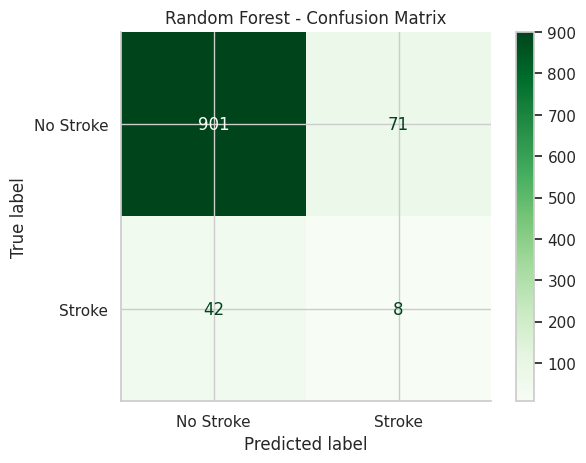

In [67]:
# Tahmin
y_pred_rf = rf_pipeline.predict(X_test)
y_pred_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

# Metrikler
print("Random Forest - Classification Report:")
print(classification_report(y_test, y_pred_rf))

roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print(f"ROC-AUC Score: {roc_auc_rf:.4f}")

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['No Stroke', 'Stroke'])
disp_rf.plot(cmap='Greens')
plt.title("Random Forest - Confusion Matrix")
plt.show()

recall cok dusuk thresholdla oynayarak dengeleyebiliriz

In [68]:
from xgboost import XGBClassifier

In [69]:
# SMOTE + StandardScaler + XGBoost Pipeline
xgb_pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('scale', StandardScaler()),
    ('classifier', XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),  # Dengesiz veri için
        eval_metric='logloss',
        use_label_encoder=False
    ))
])

print("XGBoost Eğitiliyor...")
xgb_pipeline.fit(X_train, y_train)
print("Eğitim Tamamlandı!")

XGBoost Eğitiliyor...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:14:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Eğitim Tamamlandı!


XGBoost - Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.69      0.81       972
           1       0.11      0.76      0.20        50

    accuracy                           0.69      1022
   macro avg       0.55      0.73      0.50      1022
weighted avg       0.94      0.69      0.78      1022

ROC-AUC Score: 0.7767


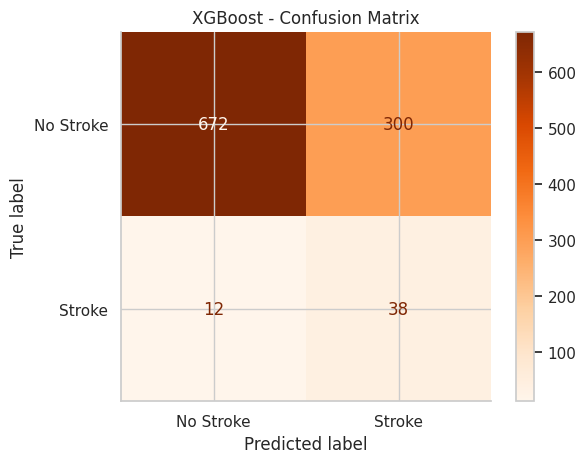

In [70]:
# Tahmin
y_pred_xgb = xgb_pipeline.predict(X_test)
y_pred_proba_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

# Metrikler
print("XGBoost - Classification Report:")
print(classification_report(y_test, y_pred_xgb))

roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
print(f"ROC-AUC Score: {roc_auc_xgb:.4f}")

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=['No Stroke', 'Stroke'])
disp_xgb.plot(cmap='Oranges')
plt.title("XGBoost - Confusion Matrix")
plt.show()

In [71]:
import pandas as pd
from sklearn.metrics import recall_score, f1_score, precision_score

# Tüm modellerin metriklerini hesapla
models = {
    'Logistic Regression': (y_pred, y_pred_proba),
    'Random Forest': (y_pred_rf, y_pred_proba_rf),
    'XGBoost': (y_pred_xgb, y_pred_proba_xgb)
}

results = []
for model_name, (pred, proba) in models.items():
    results.append({
        'Model': model_name,
        'Precision': precision_score(y_test, pred),
        'Recall': recall_score(y_test, pred),
        'F1-Score': f1_score(y_test, pred),
        'ROC-AUC': roc_auc_score(y_test, proba)
    })

results_df = pd.DataFrame(results)

print("="*70)
print("MODEL KARŞILAŞTIRMASI")
print("="*70)
print(results_df.to_string(index=False))
print("="*70)

# En iyi model (Recall'a göre - stroke için önemli!)
best_model = results_df.loc[results_df['Recall'].idxmax(), 'Model']
print(f"\nEn Yüksek Recall: {best_model}")

MODEL KARŞILAŞTIRMASI
              Model  Precision  Recall  F1-Score  ROC-AUC
Logistic Regression       0.14    0.76      0.23     0.83
      Random Forest       0.10    0.16      0.12     0.78
            XGBoost       0.11    0.76      0.20     0.78

En Yüksek Recall: Logistic Regression


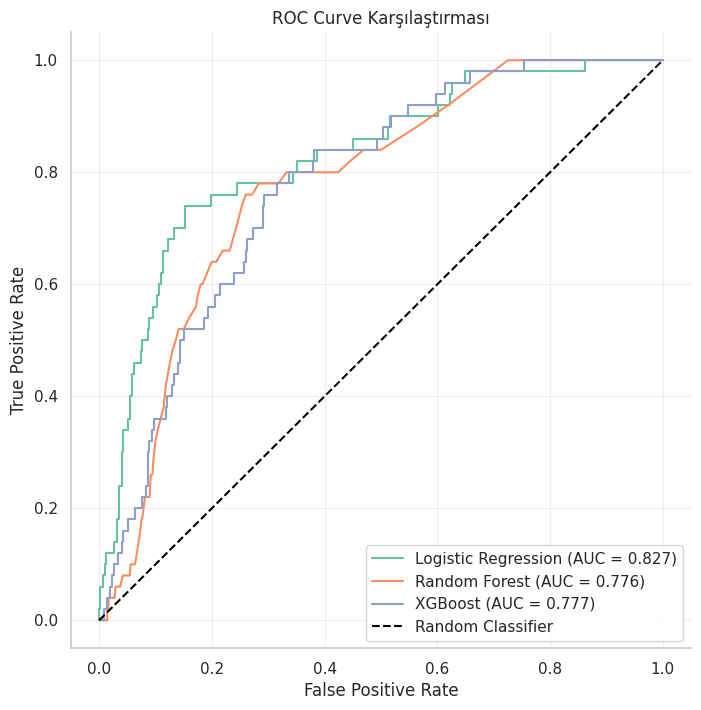

In [72]:
from sklearn.metrics import roc_curve

fig, ax = plt.subplots(figsize=(8, 8))

for model_name, (pred, proba) in models.items():
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    ax.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.3f})')

ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve Karşılaştırması')
ax.legend()
ax.grid(alpha=0.3)
plt.show()

su an logreg en iyi görünüyor tuning yapıp tekrar roc curve cizelim

In [73]:
from sklearn.model_selection import GridSearchCV

# Logistic Regression parametreleri
lr_param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['saga']
}

lr_grid = GridSearchCV(
    logreg_pipeline,
    lr_param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

print("Logistic Regression Tuning...")
lr_grid.fit(X_train, y_train)
print(f"Best params: {lr_grid.best_params_}")
print(f"Best ROC-AUC: {lr_grid.best_score_:.4f}")

Logistic Regression Tuning...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'classifier__C': 0.01, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Best ROC-AUC: 0.8324


In [74]:
rf_param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10, 15],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

rf_grid = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

print("Random Forest Tuning...")
rf_grid.fit(X_train, y_train)
print(f"Best params: {rf_grid.best_params_}")
print(f"Best ROC-AUC: {rf_grid.best_score_:.4f}")

Random Forest Tuning...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best params: {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best ROC-AUC: 0.8091


In [75]:
xgb_param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 1.0]
}

xgb_grid = GridSearchCV(
    xgb_pipeline,
    xgb_param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

print("XGBoost Tuning...")
xgb_grid.fit(X_train, y_train)
print(f"Best params: {xgb_grid.best_params_}")
print(f"Best ROC-AUC: {xgb_grid.best_score_:.4f}")

XGBoost Tuning...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best params: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 1.0}
Best ROC-AUC: 0.8115


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:17:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


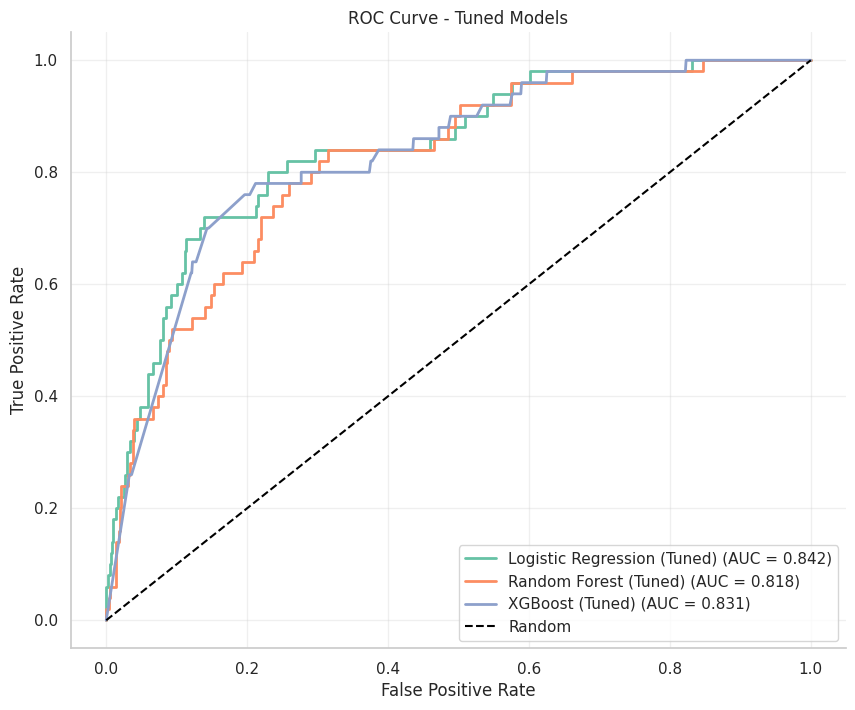

In [76]:
# En iyi modeller
best_models = {
    'Logistic Regression (Tuned)': lr_grid.best_estimator_,
    'Random Forest (Tuned)': rf_grid.best_estimator_,
    'XGBoost (Tuned)': xgb_grid.best_estimator_
}

# ROC Curve
fig, ax = plt.subplots(figsize=(10, 8))

for name, model in best_models.items():
    proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    ax.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {auc:.3f})')

ax.plot([0, 1], [0, 1], 'k--', label='Random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve - Tuned Models')
ax.legend(loc='lower right')
ax.grid(alpha=0.3)
plt.show()

ROC CURVE EN İYİ OLAN LOGISTIC REGRESSION OLDUGUNDAN MUHTEMELEN ONUNLA DEVAM EDECEGIZ
BAZI NOKTALAR İÇİN XGBOOST LOGREG'DEN DAHA IYI TPR'YE SAHİP GORUNUYOR ORNEGIN TPR=0.75 CIVARI XGBOOST FPR DEGERI DAHA DUSUK

Feature Importance (Logistic Regression):
                       Feature  Coefficient  Abs_Importance
                    age_scaled         1.82            1.82
  avg_glucose_level_log_scaled         0.20            0.20
   smoking_status_never smoked        -0.20            0.20
       work_type_Self-employed        -0.18            0.18
                   gender_Male        -0.13            0.13
          Residence_type_Urban        -0.06            0.06
             work_type_Private        -0.05            0.05
smoking_status_formerly smoked        -0.05            0.05
              ever_married_Yes        -0.05            0.05
         smoking_status_smokes        -0.01            0.01
                  hypertension         0.00            0.00
                    bmi_scaled         0.00            0.00
                 heart_disease         0.00            0.00
            work_type_children         0.00            0.00
        work_type_Never_worked         0.00            0.0

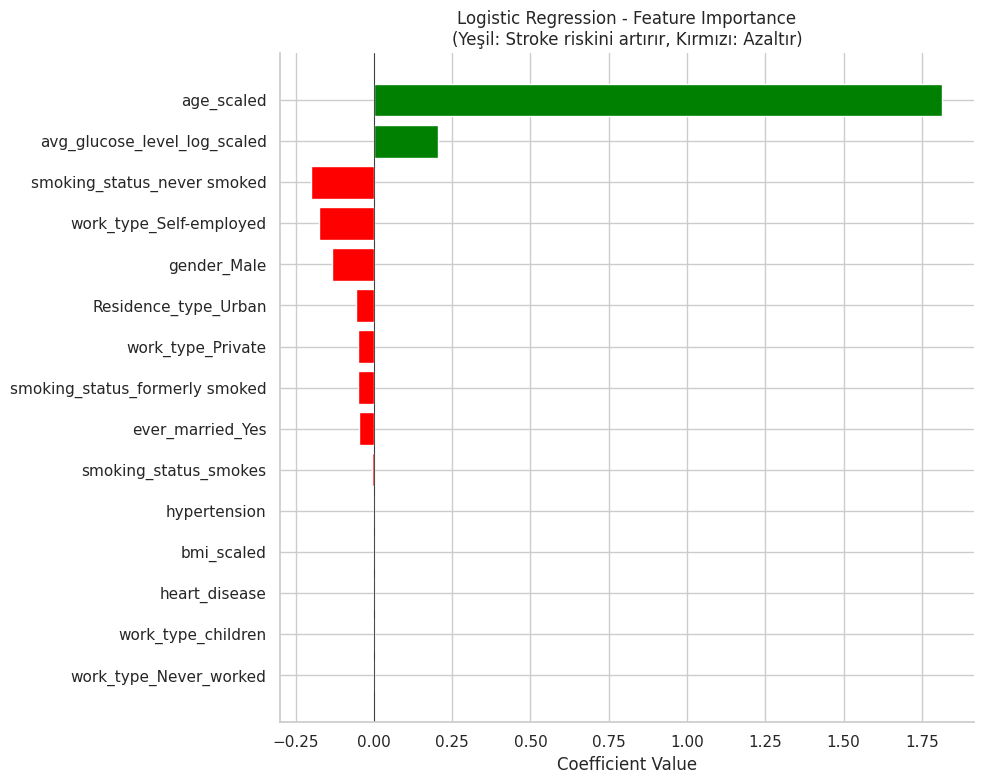

In [77]:
# Logistic Regression Coefficients (Feature Importance)
lr_coefs = lr_grid.best_estimator_.named_steps['classifier'].coef_[0]

importance_df = pd.DataFrame({
    'Feature': lr_features,
    'Coefficient': lr_coefs,
    'Abs_Importance': np.abs(lr_coefs)
}).sort_values('Abs_Importance', ascending=False)

print("Feature Importance (Logistic Regression):")
print(importance_df.to_string(index=False))

# Görselleştirme
plt.figure(figsize=(10, 8))
colors = ['green' if c > 0 else 'red' for c in importance_df['Coefficient']]
plt.barh(importance_df['Feature'], importance_df['Coefficient'], color=colors)
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression - Feature Importance\n(Yeşil: Stroke riskini artırır, Kırmızı: Azaltır)')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [78]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint


# Daha geniş parametre uzayı
param_dist = {
    'classifier__C': uniform(0.001, 100),
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['saga']
}

random_search = RandomizedSearchCV(
    logreg_pipeline,
    param_dist,
    n_iter=50,
    cv=5,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train, y_train)
print(f"Best ROC-AUC: {random_search.best_score_:.4f}")

Best ROC-AUC: 0.8100


🎯 Optimal Threshold: 0.964


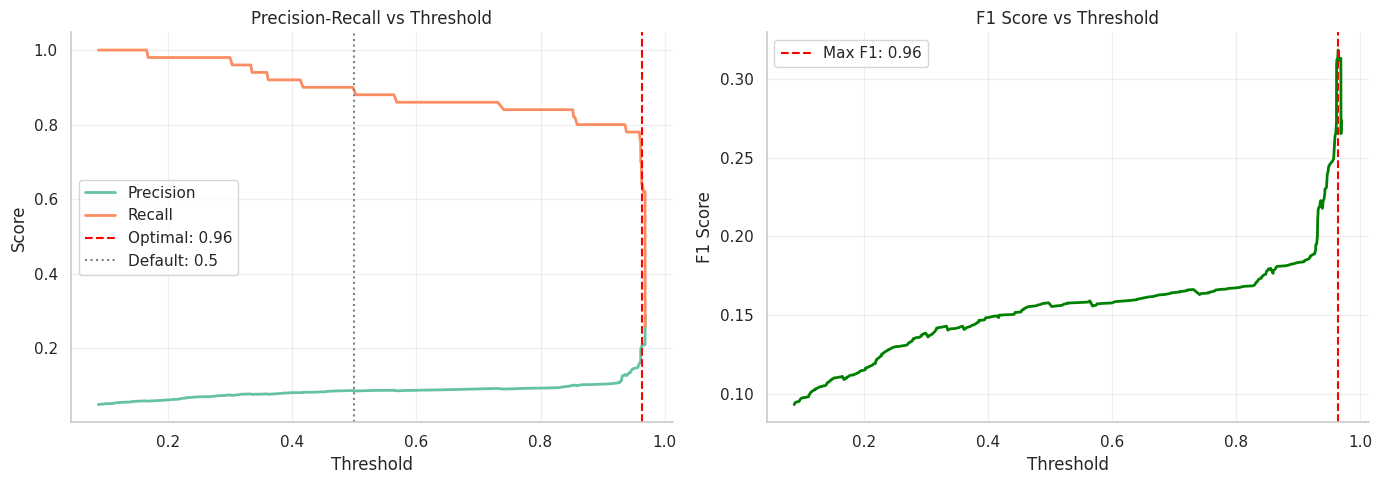

In [83]:
# Tamamı tek hücrede
from sklearn.metrics import precision_recall_curve
f1_scores = 2 * (precision_vals[:-1] * recall_vals[:-1]) / (precision_vals[:-1] + recall_vals[:-1] + 1e-8)
optimal_f1_idx = np.argmax(f1_scores)
optimal_f1_threshold = thresholds[optimal_f1_idx]
print(f"🎯 Optimal Threshold: {optimal_f1_threshold:.3f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(thresholds, precision_vals[:-1], label='Precision', linewidth=2)
axes[0].plot(thresholds, recall_vals[:-1], label='Recall', linewidth=2)
axes[0].axvline(x=optimal_f1_threshold, color='red', linestyle='--', label=f'Optimal: {optimal_f1_threshold:.2f}')
axes[0].axvline(x=0.5, color='gray', linestyle=':', label='Default: 0.5')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Score')
axes[0].set_title('Precision-Recall vs Threshold')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(thresholds, f1_scores, color='green', linewidth=2)
axes[1].axvline(x=optimal_f1_threshold, color='red', linestyle='--', label=f'Max F1: {optimal_f1_threshold:.2f}')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('F1 Score')
axes[1].set_title('F1 Score vs Threshold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [84]:
# En az önemli özellikleri çıkararak modeli basitleştir
important_features = importance_df[importance_df['Abs_Importance'] > 0.1]['Feature'].tolist()
print(f"Önemli özellikler: {important_features}")

# Sadece önemli özelliklerle yeni model
X_train_selected = X_train[important_features]
X_test_selected = X_test[important_features]

# Yeni LogReg pipeline
lr_selected_pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('scale', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'))
])

lr_selected_pipeline.fit(X_train_selected, y_train)
selected_proba = lr_selected_pipeline.predict_proba(X_test_selected)[:, 1]
print(f"Selected Features ROC-AUC: {roc_auc_score(y_test, selected_proba):.4f}")

Önemli özellikler: ['age_scaled', 'avg_glucose_level_log_scaled', 'smoking_status_never smoked', 'work_type_Self-employed', 'gender_Male']
Selected Features ROC-AUC: 0.8440


Tüm özellik sayısı: 15
Seçilen özellik sayısı: 5
Seçilen özellikler: ['age_scaled', 'avg_glucose_level_log_scaled', 'smoking_status_never smoked', 'work_type_Self-employed', 'gender_Male']


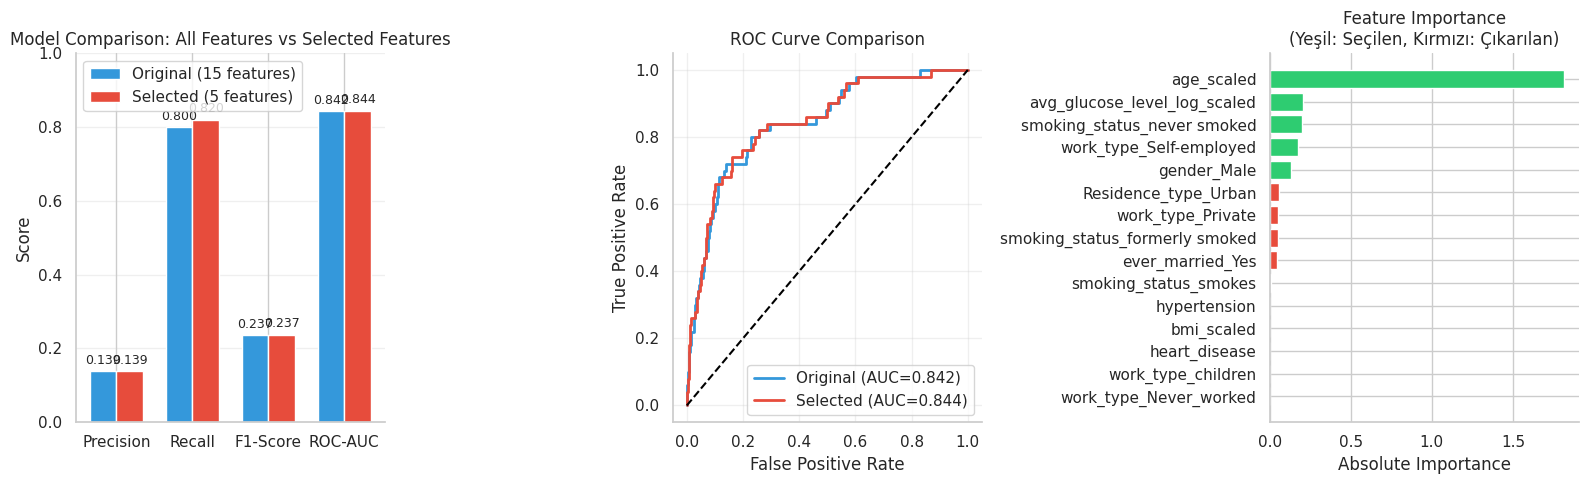


MODEL KARŞILAŞTIRMASI
                         Precision  Recall  F1-Score  ROC-AUC
Original (All Features)       0.14    0.80      0.24     0.84
Selected Features             0.14    0.82      0.24     0.84

Fark (Selected - Original):
Precision   -0.00
Recall       0.02
F1-Score     0.00
ROC-AUC      0.00


In [85]:
# 1. Önemli özellikleri seç (threshold: 0.1)
important_features = importance_df[importance_df['Abs_Importance'] > 0.1]['Feature'].tolist()
print(f"Tüm özellik sayısı: {len(lr_features)}")
print(f"Seçilen özellik sayısı: {len(important_features)}")
print(f"Seçilen özellikler: {important_features}")

# 2. Feature-selected model eğit
X_train_selected = X_train[important_features]
X_test_selected = X_test[important_features]

lr_selected_pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('scale', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'))
])

lr_selected_pipeline.fit(X_train_selected, y_train)

# 3. Her iki modelin tahminleri
# Orijinal model
y_pred_original = lr_grid.best_estimator_.predict(X_test)
proba_original = lr_grid.best_estimator_.predict_proba(X_test)[:, 1]

# Selected features model
y_pred_selected = lr_selected_pipeline.predict(X_test_selected)
proba_selected = lr_selected_pipeline.predict_proba(X_test_selected)[:, 1]

# 4. Metrikleri hesapla
models_comparison = {
    'Original (All Features)': {
        'Precision': precision_score(y_test, y_pred_original),
        'Recall': recall_score(y_test, y_pred_original),
        'F1-Score': f1_score(y_test, y_pred_original),
        'ROC-AUC': roc_auc_score(y_test, proba_original)
    },
    'Selected Features': {
        'Precision': precision_score(y_test, y_pred_selected),
        'Recall': recall_score(y_test, y_pred_selected),
        'F1-Score': f1_score(y_test, y_pred_selected),
        'ROC-AUC': roc_auc_score(y_test, proba_selected)
    }
}

# 5. Karşılaştırma grafiği
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 5a. Metrics Bar Chart Karşılaştırması
metrics_names = ['Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(metrics_names))
width = 0.35

original_vals = [models_comparison['Original (All Features)'][m] for m in metrics_names]
selected_vals = [models_comparison['Selected Features'][m] for m in metrics_names]

bars1 = axes[0].bar(x - width/2, original_vals, width, label=f'Original ({len(lr_features)} features)', color='#3498db')
bars2 = axes[0].bar(x + width/2, selected_vals, width, label=f'Selected ({len(important_features)} features)', color='#e74c3c')

axes[0].set_ylabel('Score')
axes[0].set_title('Model Comparison: All Features vs Selected Features')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_names)
axes[0].legend()
axes[0].set_ylim(0, 1)
axes[0].grid(axis='y', alpha=0.3)

# Bar değerlerini yaz
for bar in bars1:
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{bar.get_height():.3f}', ha='center', fontsize=9)
for bar in bars2:
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{bar.get_height():.3f}', ha='center', fontsize=9)

# 5b. ROC Curve Karşılaştırması
fpr_orig, tpr_orig, _ = roc_curve(y_test, proba_original)
fpr_sel, tpr_sel, _ = roc_curve(y_test, proba_selected)

axes[1].plot(fpr_orig, tpr_orig, linewidth=2,
             label=f'Original (AUC={roc_auc_score(y_test, proba_original):.3f})', color='#3498db')
axes[1].plot(fpr_sel, tpr_sel, linewidth=2,
             label=f'Selected (AUC={roc_auc_score(y_test, proba_selected):.3f})', color='#e74c3c')
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve Comparison')
axes[1].legend()
axes[1].grid(alpha=0.3)

# 5c. Feature Importance (Seçilen vs Seçilmeyen)
colors = ['#2ecc71' if f in important_features else '#e74c3c' for f in importance_df['Feature']]
axes[2].barh(importance_df['Feature'], importance_df['Abs_Importance'], color=colors)
axes[2].set_xlabel('Absolute Importance')
axes[2].set_title('Feature Importance\n(Yeşil: Seçilen, Kırmızı: Çıkarılan)')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

# 6. Sonuç tablosu
print("\n" + "="*60)
print("MODEL KARŞILAŞTIRMASI")
print("="*60)
comparison_df = pd.DataFrame(models_comparison).T
print(comparison_df.to_string())
print("="*60)

# Fark
diff = comparison_df.loc['Selected Features'] - comparison_df.loc['Original (All Features)']
print("\nFark (Selected - Original):")
print(diff.to_string())

Feature selection yaparak çok daha az feature kullanarak model kuruldu. recall değeri cok az da olsa arttı. Daha basit bir model kullanılarak aynı performansı elde edebildigimizden basit olan modeli seçmek daha mantıklı.
Bu durumda Tune ettiğimiz logreg modelini feature selection yapıp kullanabiliriz.

In [86]:
from sklearn.metrics import accuracy_score

# Her iki model için accuracy
acc_original = accuracy_score(y_test, y_pred_original)
acc_selected = accuracy_score(y_test, y_pred_selected)

print("="*50)
print("ACCURACY KARŞILAŞTIRMASI")
print("="*50)
print(f"Original (All Features):  {acc_original:.4f} ({acc_original*100:.2f}%)")
print(f"Selected Features:        {acc_selected:.4f} ({acc_selected*100:.2f}%)")
print("="*50)

# Tüm modeller için accuracy (eğer varsa)
print("\nTÜM MODELLERİN ACCURACY'Sİ:")
print("-"*50)

all_models = {
    'Logistic Regression': y_pred,
    'Random Forest': y_pred_rf,
    'XGBoost': y_pred_xgb,
    'LR (Selected Features)': y_pred_selected
}

for name, pred in all_models.items():
    acc = accuracy_score(y_test, pred)
    print(f"{name}: {acc:.4f} ({acc*100:.2f}%)")

ACCURACY KARŞILAŞTIRMASI
Original (All Features):  0.7476 (74.76%)
Selected Features:        0.7417 (74.17%)

TÜM MODELLERİN ACCURACY'Sİ:
--------------------------------------------------
Logistic Regression: 0.7573 (75.73%)
Random Forest: 0.8894 (88.94%)
XGBoost: 0.6947 (69.47%)
LR (Selected Features): 0.7417 (74.17%)


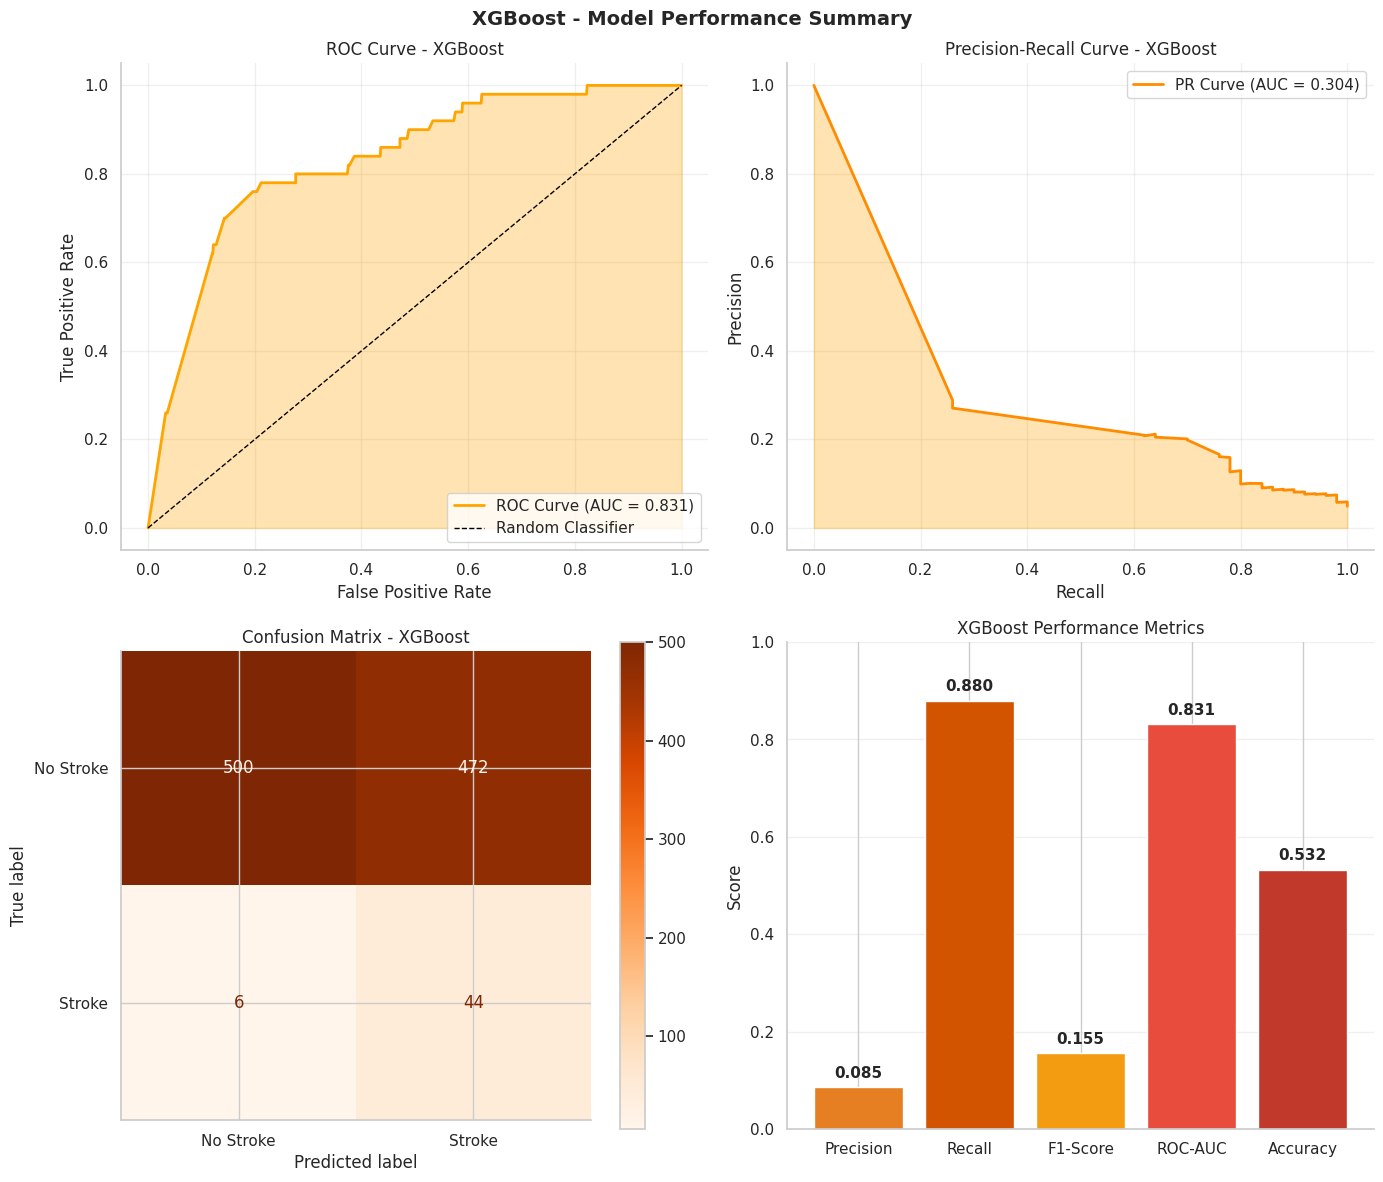


XGBOOST - FINAL METRICS
              precision    recall  f1-score   support

           0       0.99      0.51      0.68       972
           1       0.09      0.88      0.16        50

    accuracy                           0.53      1022
   macro avg       0.54      0.70      0.42      1022
weighted avg       0.94      0.53      0.65      1022

ROC-AUC: 0.8312
PR-AUC: 0.3037
Accuracy: 0.5323


In [90]:
# XGBoost için tahminler
from sklearn import metrics

y_pred_xgb = xgb_grid.best_estimator_.predict(X_test)
proba_xgb = xgb_grid.best_estimator_.predict_proba(X_test)[:, 1]

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. ROC Curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, proba_xgb)
roc_auc_xgb = metrics.auc(fpr_xgb, tpr_xgb)
axes[0, 0].plot(fpr_xgb, tpr_xgb, color='orange', linewidth=2, label=f'ROC Curve (AUC = {roc_auc_xgb:.3f})')
axes[0, 0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[0, 0].fill_between(fpr_xgb, tpr_xgb, alpha=0.3, color='orange')
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('ROC Curve - XGBoost')
axes[0, 0].legend(loc='lower right')
axes[0, 0].grid(alpha=0.3)

# 2. Precision-Recall Curve
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, proba_xgb)
pr_auc_xgb = metrics.auc(recall_xgb, precision_xgb)
axes[0, 1].plot(recall_xgb, precision_xgb, color='darkorange', linewidth=2, label=f'PR Curve (AUC = {pr_auc_xgb:.3f})')
axes[0, 1].fill_between(recall_xgb, precision_xgb, alpha=0.3, color='orange')
axes[0, 1].set_xlabel('Recall')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Precision-Recall Curve - XGBoost')
axes[0, 1].legend(loc='upper right')
axes[0, 1].grid(alpha=0.3)

# 3. Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=['No Stroke', 'Stroke'])
disp_xgb.plot(ax=axes[1, 0], cmap='Oranges')
axes[1, 0].set_title('Confusion Matrix - XGBoost')

# 4. Metrics Bar Chart
metrics_xgb = {
    'Precision': precision_score(y_test, y_pred_xgb),
    'Recall': recall_score(y_test, y_pred_xgb),
    'F1-Score': f1_score(y_test, y_pred_xgb),
    'ROC-AUC': roc_auc_xgb,
    'Accuracy': accuracy_score(y_test, y_pred_xgb)
}
colors = ['#e67e22', '#d35400', '#f39c12', '#e74c3c', '#c0392b']
bars = axes[1, 1].bar(metrics_xgb.keys(), metrics_xgb.values(), color=colors)
axes[1, 1].set_ylim(0, 1)
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('XGBoost Performance Metrics')
axes[1, 1].grid(axis='y', alpha=0.3)

for bar, val in zip(bars, metrics_xgb.values()):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                     f'{val:.3f}', ha='center', fontsize=11, fontweight='bold')

plt.suptitle('XGBoost - Model Performance Summary', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Metrikleri yazdır
print("\n" + "="*50)
print("XGBOOST - FINAL METRICS")
print("="*50)
print(classification_report(y_test, y_pred_xgb))
print(f"ROC-AUC: {roc_auc_xgb:.4f}")
print(f"PR-AUC: {pr_auc_xgb:.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")

recall logregden daha iyi gibi görünüyor tekrardan bi roc curve karsılastıralım

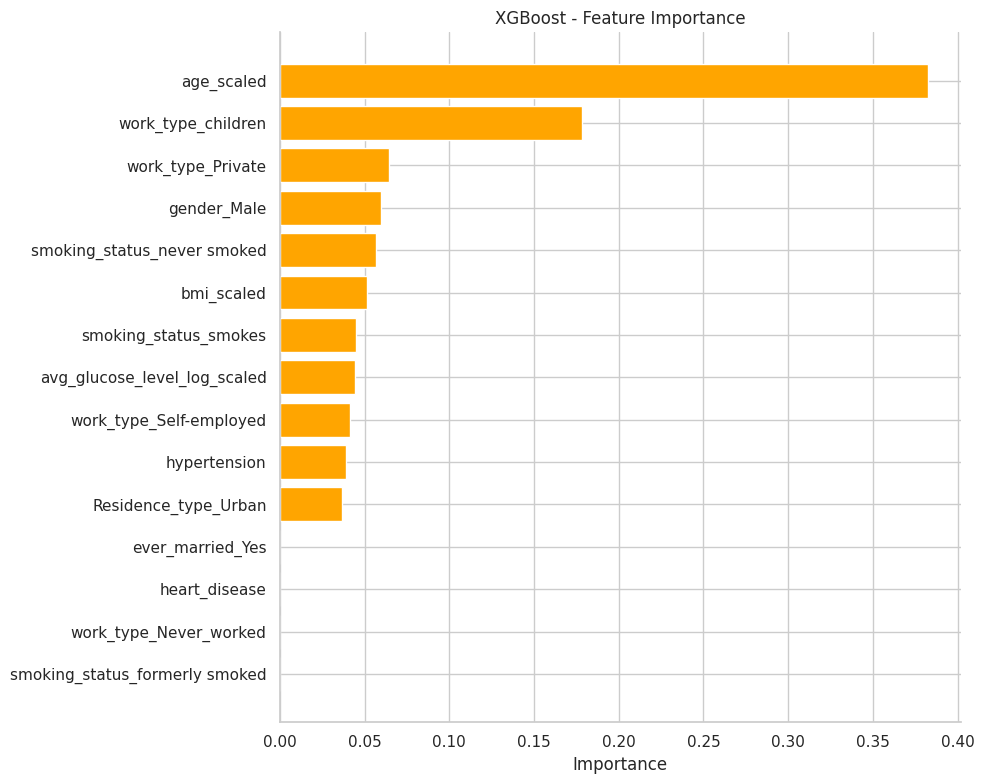

In [91]:
# XGBoost feature importance
xgb_importance = xgb_grid.best_estimator_.named_steps['classifier'].feature_importances_
xgb_importance_df = pd.DataFrame({
    'Feature': lr_features,
    'Importance': xgb_importance
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(xgb_importance_df['Feature'], xgb_importance_df['Importance'], color='orange')
plt.xlabel('Importance')
plt.title('XGBoost - Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [92]:
# 1. XGBoost importance'a göre önemli özellikleri seç
threshold = 0.05  # %5'ten fazla importance
xgb_important_features = xgb_importance_df[xgb_importance_df['Importance'] > threshold]['Feature'].tolist()

print(f"Tüm özellik sayısı: {len(lr_features)}")
print(f"XGBoost seçilen özellik sayısı: {len(xgb_important_features)}")
print(f"Seçilen özellikler: {xgb_important_features}")

# 2. Selected features ile yeni XGBoost modeli
X_train_xgb_selected = X_train[xgb_important_features]
X_test_xgb_selected = X_test[xgb_important_features]

xgb_selected_pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('scale', StandardScaler()),
    ('classifier', XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
        eval_metric='logloss'
    ))
])

print("\nXGBoost (Selected Features) Eğitiliyor...")
xgb_selected_pipeline.fit(X_train_xgb_selected, y_train)

# 3. Tahminler
y_pred_xgb_selected = xgb_selected_pipeline.predict(X_test_xgb_selected)
proba_xgb_selected = xgb_selected_pipeline.predict_proba(X_test_xgb_selected)[:, 1]

# 4. Karşılaştırma
print("\n" + "="*60)
print("XGBOOST: ORIGINAL vs SELECTED FEATURES")
print("="*60)

comparison = {
    'Metric': ['Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Accuracy'],
    f'Original ({len(lr_features)} features)': [
        precision_score(y_test, y_pred_xgb),
        recall_score(y_test, y_pred_xgb),
        f1_score(y_test, y_pred_xgb),
        roc_auc_score(y_test, proba_xgb),
        accuracy_score(y_test, y_pred_xgb)
    ],
    f'Selected ({len(xgb_important_features)} features)': [
        precision_score(y_test, y_pred_xgb_selected),
        recall_score(y_test, y_pred_xgb_selected),
        f1_score(y_test, y_pred_xgb_selected),
        roc_auc_score(y_test, proba_xgb_selected),
        accuracy_score(y_test, y_pred_xgb_selected)
    ]
}

comp_df = pd.DataFrame(comparison)
print(comp_df.to_string(index=False))

Tüm özellik sayısı: 15
XGBoost seçilen özellik sayısı: 6
Seçilen özellikler: ['age_scaled', 'work_type_children', 'work_type_Private', 'gender_Male', 'smoking_status_never smoked', 'bmi_scaled']

XGBoost (Selected Features) Eğitiliyor...

XGBOOST: ORIGINAL vs SELECTED FEATURES
   Metric  Original (15 features)  Selected (6 features)
Precision                    0.09                   0.10
   Recall                    0.88                   0.82
 F1-Score                    0.16                   0.18
  ROC-AUC                    0.83                   0.77
 Accuracy                    0.53                   0.63


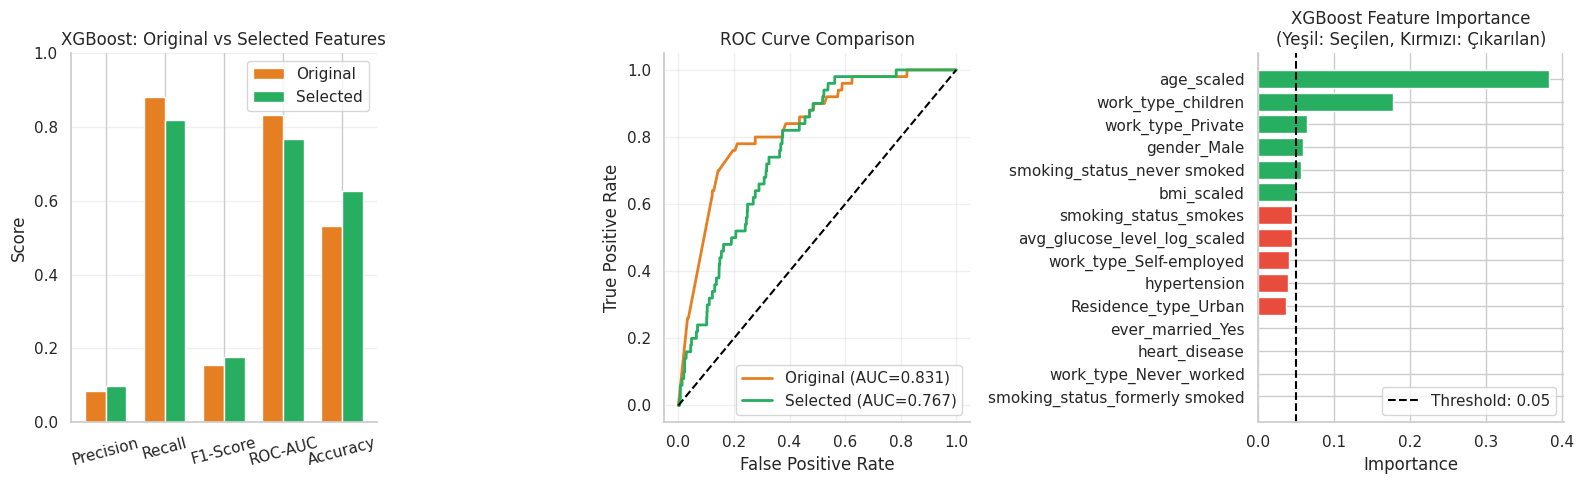

In [93]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Metrics Bar Chart
metrics_names = ['Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Accuracy']
x = np.arange(len(metrics_names))
width = 0.35

orig_vals = comparison[f'Original ({len(lr_features)} features)']
sel_vals = comparison[f'Selected ({len(xgb_important_features)} features)']

bars1 = axes[0].bar(x - width/2, orig_vals, width, label=f'Original', color='#e67e22')
bars2 = axes[0].bar(x + width/2, sel_vals, width, label=f'Selected', color='#27ae60')

axes[0].set_ylabel('Score')
axes[0].set_title('XGBoost: Original vs Selected Features')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_names, rotation=15)
axes[0].legend()
axes[0].set_ylim(0, 1)
axes[0].grid(axis='y', alpha=0.3)

# 2. ROC Curve
fpr_orig, tpr_orig, _ = roc_curve(y_test, proba_xgb)
fpr_sel, tpr_sel, _ = roc_curve(y_test, proba_xgb_selected)

axes[1].plot(fpr_orig, tpr_orig, linewidth=2,
             label=f'Original (AUC={roc_auc_score(y_test, proba_xgb):.3f})', color='#e67e22')
axes[1].plot(fpr_sel, tpr_sel, linewidth=2,
             label=f'Selected (AUC={roc_auc_score(y_test, proba_xgb_selected):.3f})', color='#27ae60')
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve Comparison')
axes[1].legend()
axes[1].grid(alpha=0.3)

# 3. Feature Importance (Seçilen vs Çıkarılan)
colors = ['#27ae60' if f in xgb_important_features else '#e74c3c' for f in xgb_importance_df['Feature']]
axes[2].barh(xgb_importance_df['Feature'], xgb_importance_df['Importance'], color=colors)
axes[2].axvline(x=threshold, color='black', linestyle='--', label=f'Threshold: {threshold}')
axes[2].set_xlabel('Importance')
axes[2].set_title('XGBoost Feature Importance\n(Yeşil: Seçilen, Kırmızı: Çıkarılan)')
axes[2].legend()
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()


XGBoost algoritması için feature selection o kadar iyi bir performans vermedi ilk hali ile feature selection yaptıgımız logreg modelini karsılastırıp son kararı verecegiz

In [94]:
# Final Karşılaştırma: LogReg (Selected) vs XGBoost (Original)

# LogReg Selected Features tahminleri (önceden hesapladık)
# y_pred_selected, proba_selected

# XGBoost Original tahminleri
y_pred_xgb_orig = xgb_grid.best_estimator_.predict(X_test)
proba_xgb_orig = xgb_grid.best_estimator_.predict_proba(X_test)[:, 1]

# Metrikleri hesapla
final_comparison = {
    'Metric': ['Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Accuracy'],
    f'LogReg Selected ({len(important_features)} features)': [
        precision_score(y_test, y_pred_selected),
        recall_score(y_test, y_pred_selected),
        f1_score(y_test, y_pred_selected),
        roc_auc_score(y_test, proba_selected),
        accuracy_score(y_test, y_pred_selected)
    ],
    f'XGBoost Original ({len(lr_features)} features)': [
        precision_score(y_test, y_pred_xgb_orig),
        recall_score(y_test, y_pred_xgb_orig),
        f1_score(y_test, y_pred_xgb_orig),
        roc_auc_score(y_test, proba_xgb_orig),
        accuracy_score(y_test, y_pred_xgb_orig)
    ]
}

final_df = pd.DataFrame(final_comparison)

# Kazanan
lr_auc = roc_auc_score(y_test, proba_selected)
xgb_auc = roc_auc_score(y_test, proba_xgb_orig)
lr_recall = recall_score(y_test, y_pred_selected)
xgb_recall = recall_score(y_test, y_pred_xgb_orig)

print(f"\n📊 ROC-AUC: LogReg={lr_auc:.4f} vs XGBoost={xgb_auc:.4f}")
print(f"🩺 Recall:  LogReg={lr_recall:.4f} vs XGBoost={xgb_recall:.4f}")


📊 ROC-AUC: LogReg=0.8440 vs XGBoost=0.8312
🩺 Recall:  LogReg=0.8200 vs XGBoost=0.8800


/tmp/ipython-input-2838744322.py:57: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2838744322.py:57: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2838744322.py:57: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


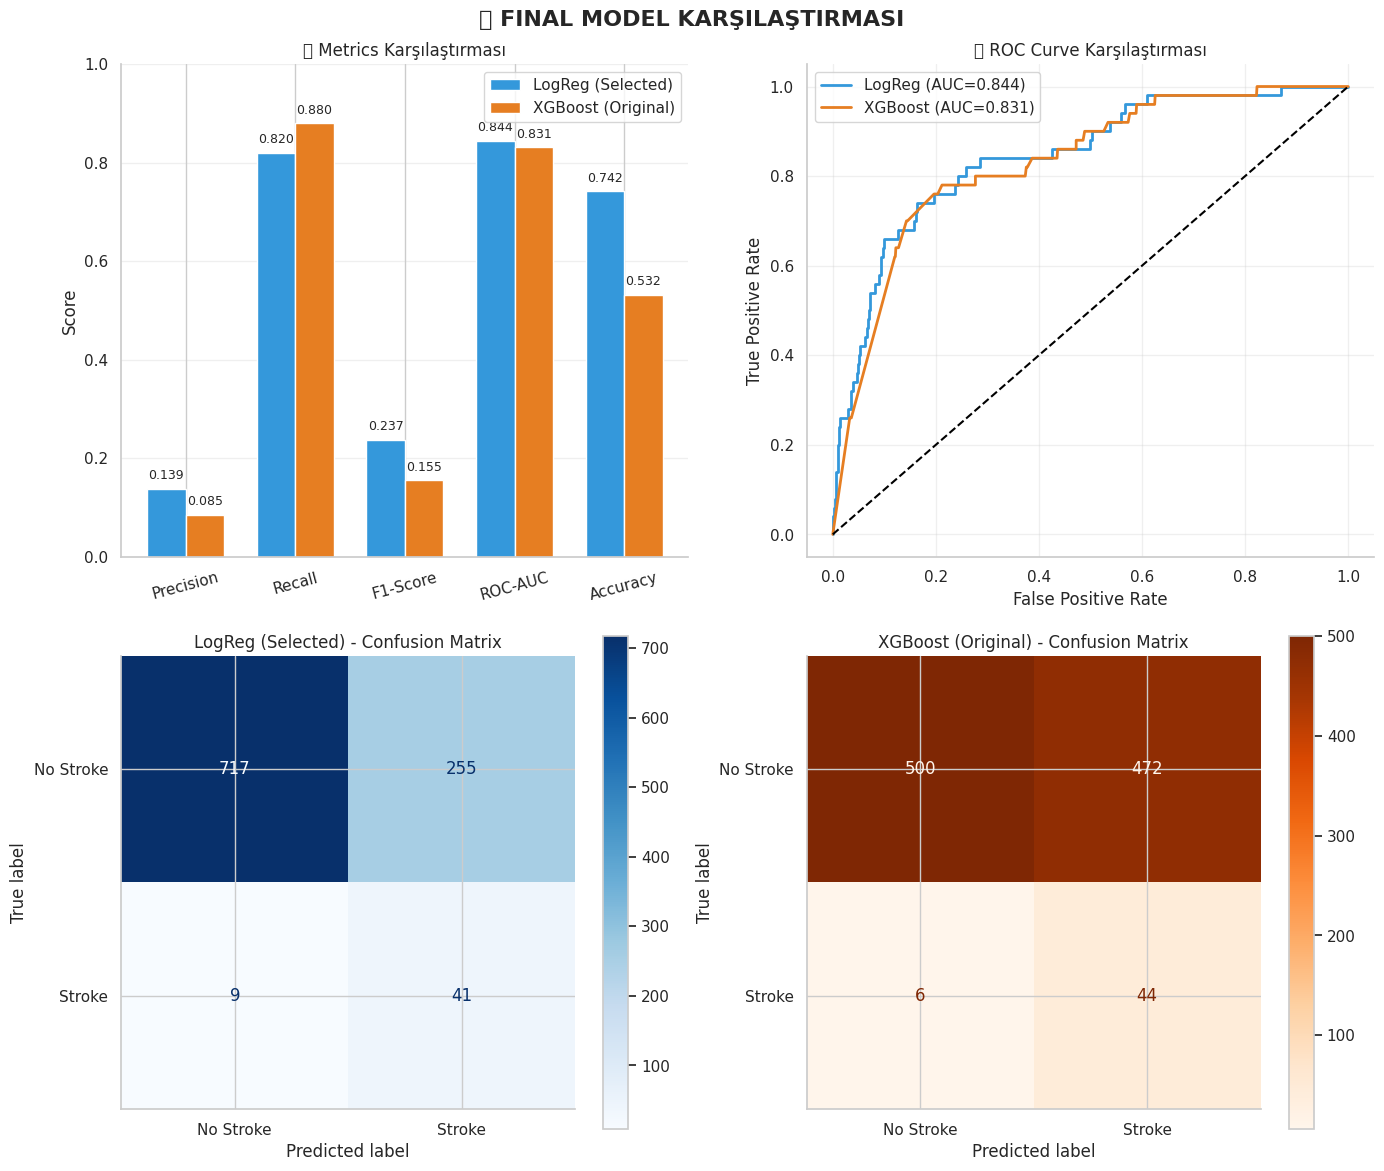

In [95]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Metrics Karşılaştırması
metrics_names = ['Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Accuracy']
x = np.arange(len(metrics_names))
width = 0.35

lr_vals = final_comparison[f'LogReg Selected ({len(important_features)} features)']
xgb_vals = final_comparison[f'XGBoost Original ({len(lr_features)} features)']

bars1 = axes[0, 0].bar(x - width/2, lr_vals, width, label='LogReg (Selected)', color='#3498db')
bars2 = axes[0, 0].bar(x + width/2, xgb_vals, width, label='XGBoost (Original)', color='#e67e22')

axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('📊 Metrics Karşılaştırması')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metrics_names, rotation=15)
axes[0, 0].legend()
axes[0, 0].set_ylim(0, 1)
axes[0, 0].grid(axis='y', alpha=0.3)

for bar in bars1:
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                     f'{bar.get_height():.3f}', ha='center', fontsize=9)
for bar in bars2:
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                     f'{bar.get_height():.3f}', ha='center', fontsize=9)

# 2. ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, proba_selected)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, proba_xgb_orig)

axes[0, 1].plot(fpr_lr, tpr_lr, linewidth=2,
                label=f'LogReg (AUC={lr_auc:.3f})', color='#3498db')
axes[0, 1].plot(fpr_xgb, tpr_xgb, linewidth=2,
                label=f'XGBoost (AUC={xgb_auc:.3f})', color='#e67e22')
axes[0, 1].plot([0, 1], [0, 1], 'k--')
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('📈 ROC Curve Karşılaştırması')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Confusion Matrix - LogReg
cm_lr = confusion_matrix(y_test, y_pred_selected)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=['No Stroke', 'Stroke'])
disp_lr.plot(ax=axes[1, 0], cmap='Blues')
axes[1, 0].set_title('LogReg (Selected) - Confusion Matrix')

# 4. Confusion Matrix - XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb_orig)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=['No Stroke', 'Stroke'])
disp_xgb.plot(ax=axes[1, 1], cmap='Oranges')
axes[1, 1].set_title('XGBoost (Original) - Confusion Matrix')

plt.suptitle('🏆 FINAL MODEL KARŞILAŞTIRMASI', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


LogReg Optimal Threshold: 0.769
XGBoost Optimal Threshold: 0.964


/tmp/ipython-input-1423321349.py:74: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


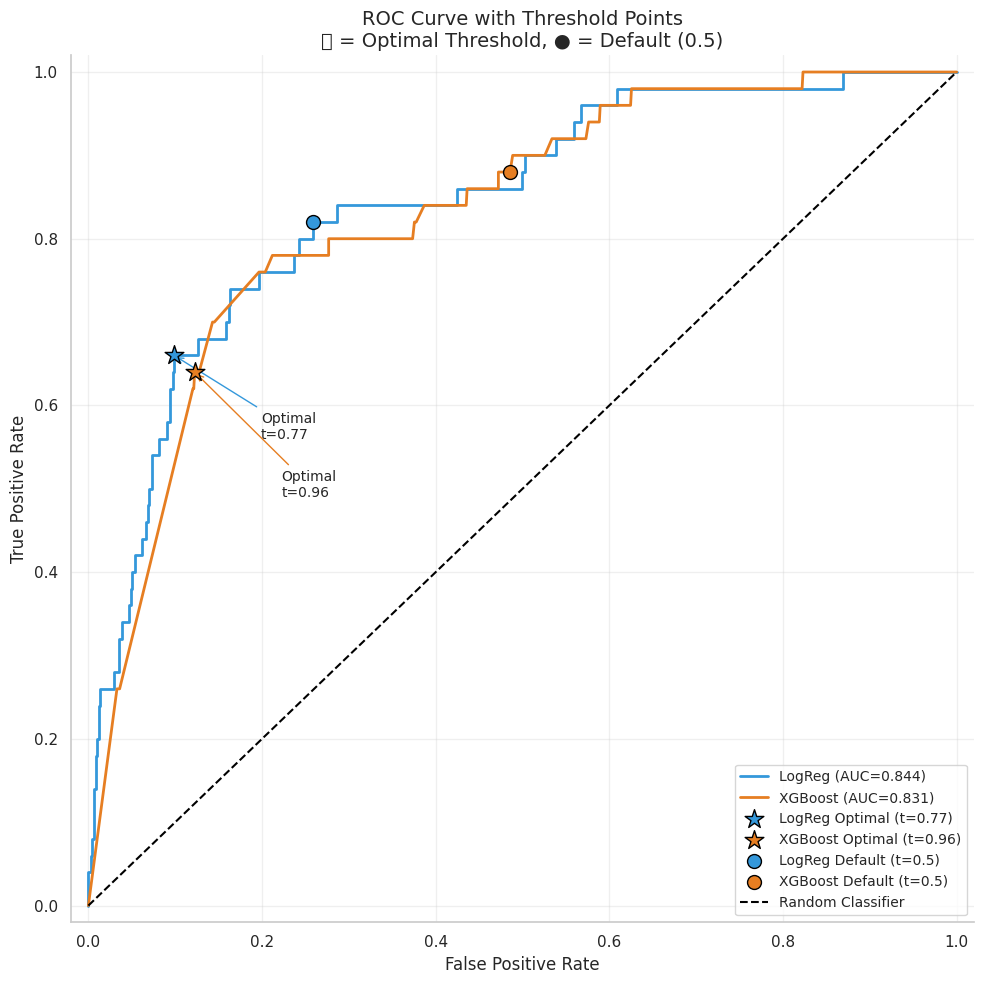

In [96]:
# Her iki model için optimal threshold bul
from sklearn.metrics import precision_recall_curve

# LogReg optimal threshold
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_test, proba_selected)
f1_lr = 2 * (precision_lr[:-1] * recall_lr[:-1]) / (precision_lr[:-1] + recall_lr[:-1] + 1e-8)
optimal_thresh_lr = thresholds_lr[np.argmax(f1_lr)]

# XGBoost optimal threshold
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_test, proba_xgb_orig)
f1_xgb = 2 * (precision_xgb[:-1] * recall_xgb[:-1]) / (precision_xgb[:-1] + recall_xgb[:-1] + 1e-8)
optimal_thresh_xgb = thresholds_xgb[np.argmax(f1_xgb)]

print(f"LogReg Optimal Threshold: {optimal_thresh_lr:.3f}")
print(f"XGBoost Optimal Threshold: {optimal_thresh_xgb:.3f}")

# ROC Curve için threshold noktalarını hesapla
fpr_lr, tpr_lr, roc_thresholds_lr = roc_curve(y_test, proba_selected)
fpr_xgb, tpr_xgb, roc_thresholds_xgb = roc_curve(y_test, proba_xgb_orig)

# Optimal threshold'a en yakın noktayı bul
def find_threshold_point(thresholds, target_thresh, fpr, tpr):
    idx = np.argmin(np.abs(thresholds - target_thresh))
    return fpr[idx], tpr[idx], thresholds[idx]

# LogReg threshold noktası
fpr_lr_opt, tpr_lr_opt, _ = find_threshold_point(roc_thresholds_lr, optimal_thresh_lr, fpr_lr, tpr_lr)

# XGBoost threshold noktası
fpr_xgb_opt, tpr_xgb_opt, _ = find_threshold_point(roc_thresholds_xgb, optimal_thresh_xgb, fpr_xgb, tpr_xgb)

# Default 0.5 threshold noktaları
fpr_lr_05, tpr_lr_05, _ = find_threshold_point(roc_thresholds_lr, 0.5, fpr_lr, tpr_lr)
fpr_xgb_05, tpr_xgb_05, _ = find_threshold_point(roc_thresholds_xgb, 0.5, fpr_xgb, tpr_xgb)

# Grafik
fig, ax = plt.subplots(figsize=(10, 10))

# ROC Curves
ax.plot(fpr_lr, tpr_lr, linewidth=2, color='#3498db',
        label=f'LogReg (AUC={roc_auc_score(y_test, proba_selected):.3f})')
ax.plot(fpr_xgb, tpr_xgb, linewidth=2, color='#e67e22',
        label=f'XGBoost (AUC={roc_auc_score(y_test, proba_xgb_orig):.3f})')

# Optimal threshold noktaları
ax.scatter(fpr_lr_opt, tpr_lr_opt, s=200, c='#3498db', marker='*', edgecolors='black',
           zorder=5, label=f'LogReg Optimal (t={optimal_thresh_lr:.2f})')
ax.scatter(fpr_xgb_opt, tpr_xgb_opt, s=200, c='#e67e22', marker='*', edgecolors='black',
           zorder=5, label=f'XGBoost Optimal (t={optimal_thresh_xgb:.2f})')

# Default 0.5 threshold noktaları
ax.scatter(fpr_lr_05, tpr_lr_05, s=100, c='#3498db', marker='o', edgecolors='black',
           zorder=5, label=f'LogReg Default (t=0.5)')
ax.scatter(fpr_xgb_05, tpr_xgb_05, s=100, c='#e67e22', marker='o', edgecolors='black',
           zorder=5, label=f'XGBoost Default (t=0.5)')

# Annotations
ax.annotate(f'Optimal\nt={optimal_thresh_lr:.2f}',
            xy=(fpr_lr_opt, tpr_lr_opt), xytext=(fpr_lr_opt+0.1, tpr_lr_opt-0.1),
            fontsize=10, arrowprops=dict(arrowstyle='->', color='#3498db'))
ax.annotate(f'Optimal\nt={optimal_thresh_xgb:.2f}',
            xy=(fpr_xgb_opt, tpr_xgb_opt), xytext=(fpr_xgb_opt+0.1, tpr_xgb_opt-0.15),
            fontsize=10, arrowprops=dict(arrowstyle='->', color='#e67e22'))

ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve with Threshold Points\n⭐ = Optimal Threshold, ● = Default (0.5)', fontsize=14)
ax.legend(loc='lower right', fontsize=10)
ax.grid(alpha=0.3)
ax.set_xlim(-0.02, 1.02)
ax.set_ylim(-0.02, 1.02)

plt.tight_layout()
plt.show()

önceki grafikte xgboost algoritmasının recall degerinin yuksek cıkmasının sebebi seçilen threshold degeridir. benzer bir threshold degeri ile logreg algoritması da yüksek recall degeri verebilir.
hem daha basit oldugu icin hem de daha iyi roc curve'e sahip oldugu icin logreg algoritmasını tercih etmek daha mantıklıdır.
peki ya threshold degerini nasıl seçmeliyiz? recall bizim için çok önemli olduğu için thresholdu düşürebiliriz.
f1 için optimal olan t=0.77 default t=0.5 bunların arasındaki farkı gormek icin confusion matrix cizip bakalım


LOGREG THRESHOLD KARŞILAŞTIRMASI

Metric          t=0.5 (Default)      t=0.77 (Optimal)    
------------------------------------------------------------
Precision       0.1385               0.2500              
Recall          0.8200               0.6400              
F1-Score        0.2370               0.3596              


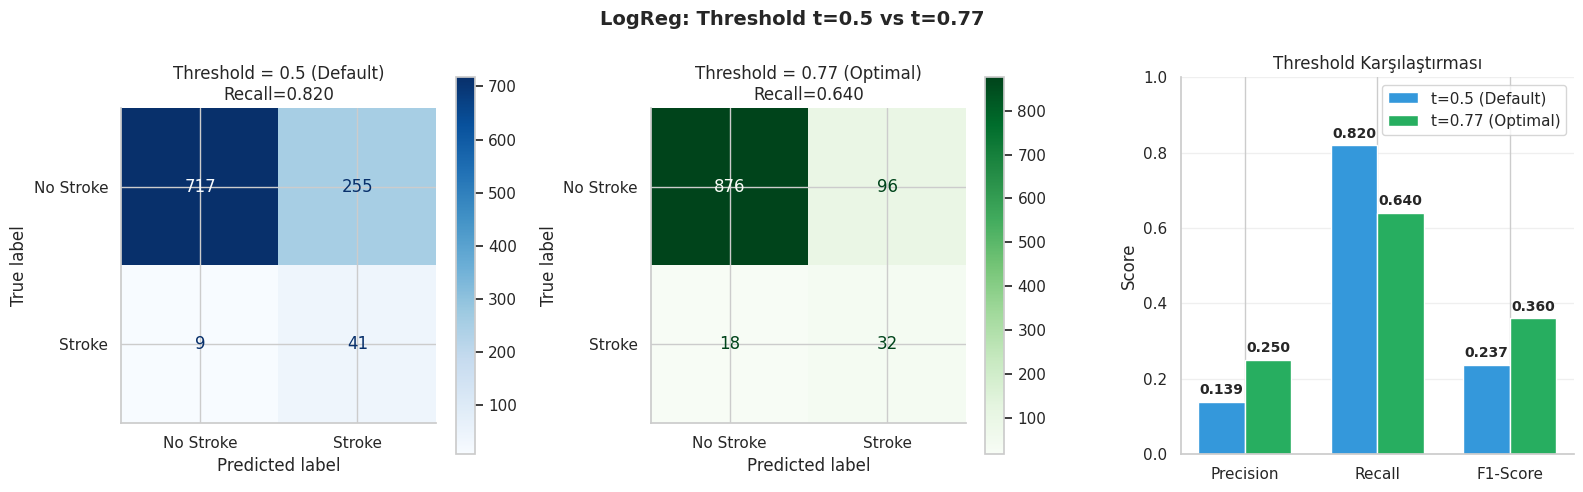

In [97]:
# Threshold değerleri
threshold_optimal = 0.77
threshold_default = 0.5

# Tahminler
y_pred_optimal = (proba_selected >= threshold_optimal).astype(int)
y_pred_default = (proba_selected >= threshold_default).astype(int)

# Metrikler
metrics_optimal = {
    'Precision': precision_score(y_test, y_pred_optimal),
    'Recall': recall_score(y_test, y_pred_optimal),
    'F1-Score': f1_score(y_test, y_pred_optimal)
}

metrics_default = {
    'Precision': precision_score(y_test, y_pred_default),
    'Recall': recall_score(y_test, y_pred_default),
    'F1-Score': f1_score(y_test, y_pred_default)
}

print("="*60)
print("LOGREG THRESHOLD KARŞILAŞTIRMASI")
print("="*60)
print(f"\n{'Metric':<15} {'t=0.5 (Default)':<20} {'t=0.77 (Optimal)':<20}")
print("-"*60)
for metric in ['Precision', 'Recall', 'F1-Score']:
    print(f"{metric:<15} {metrics_default[metric]:<20.4f} {metrics_optimal[metric]:<20.4f}")
print("="*60)

# Görselleştirme
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Confusion Matrix - Default (t=0.5)
cm_default = confusion_matrix(y_test, y_pred_default)
disp_default = ConfusionMatrixDisplay(confusion_matrix=cm_default, display_labels=['No Stroke', 'Stroke'])
disp_default.plot(ax=axes[0], cmap='Blues')
axes[0].set_title(f'Threshold = 0.5 (Default)\nRecall={metrics_default["Recall"]:.3f}', fontsize=12)

# 2. Confusion Matrix - Optimal (t=0.77)
cm_optimal = confusion_matrix(y_test, y_pred_optimal)
disp_optimal = ConfusionMatrixDisplay(confusion_matrix=cm_optimal, display_labels=['No Stroke', 'Stroke'])
disp_optimal.plot(ax=axes[1], cmap='Greens')
axes[1].set_title(f'Threshold = 0.77 (Optimal)\nRecall={metrics_optimal["Recall"]:.3f}', fontsize=12)

# 3. Metrics Bar Chart Karşılaştırması
metrics_names = ['Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics_names))
width = 0.35

default_vals = [metrics_default[m] for m in metrics_names]
optimal_vals = [metrics_optimal[m] for m in metrics_names]

bars1 = axes[2].bar(x - width/2, default_vals, width, label='t=0.5 (Default)', color='#3498db')
bars2 = axes[2].bar(x + width/2, optimal_vals, width, label='t=0.77 (Optimal)', color='#27ae60')

axes[2].set_ylabel('Score')
axes[2].set_title('Threshold Karşılaştırması')
axes[2].set_xticks(x)
axes[2].set_xticklabels(metrics_names)
axes[2].legend()
axes[2].set_ylim(0, 1)
axes[2].grid(axis='y', alpha=0.3)

# Bar değerlerini yaz
for bar in bars1:
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{bar.get_height():.3f}', ha='center', fontsize=10, fontweight='bold')
for bar in bars2:
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{bar.get_height():.3f}', ha='center', fontsize=10, fontweight='bold')

plt.suptitle('LogReg: Threshold t=0.5 vs t=0.77', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Recall bizim için çok onemli oldugu icin bu tradeoff'ta f1 için optimal olan threshold yerine default threshold kullanilmasi daha iyi olabilir.

In [98]:
import pickle

with open('stroke_model.pkl', 'wb') as f:
    pickle.dump({
        'model': lr_selected_pipeline,
        'features': important_features,
        'threshold': 0.5
    }, f)
print("✅ Model paketi kaydedildi!")

✅ Model paketi kaydedildi!
